# **ICU Mortality and Length of Stay Prediction -  using EHR Data**

This project focuses on the following major areas:
-	**ICU Mortality Prediction:** Predicting the likelihood of in-hospital mortality based on the first 24 hours of clinical data.

-	**Length of Stay Prediction:** Predicting length of ICU stays (for shorter stay period, where LOS <=7 days).


---

**Dataset:** MIMIC-IV EHR data (Link: https://physionet.org/content/mimiciv/3.1/)




## **Install Dependencies**


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.5 MB/s eta 0:00:00


## **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# Model selection, preprocessing, and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
                             median_absolute_error, precision_recall_curve, average_precision_score, roc_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Imputation and Feature Selection
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Classification models
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Regression models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# For handling imbalanced data in classification
from imblearn.under_sampling import RandomUnderSampler

from sklearn.calibration import calibration_curve


## **Data Loading :** Loading Raw Files as dataframes

In [ ]:
# Path to MIMIC-IV raw zip files in personal google drive
drive_path_raw = "/content/drive/MyDrive/EHR Analysis/Raw Files"

In [ ]:
# Load ICU stays data - icustays and admissions
# Load patients data
# Load lab items index file
# Load Diagnosis data

#Keeping only the required columns
icu_df = pd.read_csv(os.path.join(drive_path_raw, "icustays.csv.gz"), usecols=["subject_id", "hadm_id", "stay_id", "first_careunit", "intime", "outtime","los"], parse_dates=['intime', 'outtime'])
admissions_df = pd.read_csv(os.path.join(drive_path_raw, "admissions.csv.gz"),
                            usecols=["subject_id", "hadm_id", "deathtime","admission_type","admission_location", "race","hospital_expire_flag"],
                            parse_dates=['deathtime'])

patients_df = pd.read_csv(os.path.join(drive_path_raw, "patients.csv.gz"), usecols=["subject_id", "gender","anchor_age"])
labitems_df = pd.read_csv(os.path.join(drive_path_raw, "d_labitems.csv.gz"), usecols=["itemid", "label"])
diagnosis_df = pd.read_csv(os.path.join(drive_path_raw, "diagnoses_icd.csv.gz"))

**Reading files with large size using chunking**

In [ ]:
# Load labevents
# Read file in chunks

chunk_size = 500_000
chunks = []

for chunk in pd.read_csv(os.path.join(drive_path_raw, "labevents.csv.gz"), compression="gzip", chunksize=chunk_size,
                         usecols=["subject_id", "hadm_id", "itemid", "valuenum", "charttime"], parse_dates=['charttime']):
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
labevents_df = pd.concat(chunks, ignore_index=True)

print(labevents_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158374764 entries, 0 to 158374763
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   subject_id  int64         
 1   hadm_id     float64       
 2   itemid      int64         
 3   charttime   datetime64[ns]
 4   valuenum    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 5.9 GB
None


In [ ]:
# Load Chartevents
# Read file in chunks

chunk_size = 500_000
chunks = []

for chunk in pd.read_csv(os.path.join(drive_path_raw, "chartevents.csv.gz"), compression="gzip", chunksize=chunk_size,
                         usecols=["subject_id", "hadm_id", "stay_id", "valuenum", "charttime","itemid"], parse_dates=['charttime']):
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
chartevents_df = pd.concat(chunks, ignore_index=True)

print(chartevents_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432997491 entries, 0 to 432997490
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   subject_id  int64         
 1   hadm_id     int64         
 2   stay_id     int64         
 3   charttime   datetime64[ns]
 4   itemid      int64         
 5   valuenum    float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 19.4 GB
None


## **Data Integration :** Understanding the tables and processing

### **ICU_Stay Table**

In [ ]:
icu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94458 entries, 0 to 94457
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subject_id      94458 non-null  int64         
 1   hadm_id         94458 non-null  int64         
 2   stay_id         94458 non-null  int64         
 3   first_careunit  94458 non-null  object        
 4   intime          94458 non-null  datetime64[ns]
 5   outtime         94444 non-null  datetime64[ns]
 6   los             94444 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 5.0+ MB


In [ ]:
icu_df['first_careunit'].value_counts()

,count
first_careunit,
Medical Intensive Care Unit (MICU),20703
Medical/Surgical Intensive Care Unit (MICU/SICU),15449
Cardiac Vascular Intensive Care Unit (CVICU),14771
Surgical Intensive Care Unit (SICU),13009
Coronary Care Unit (CCU),10775
Trauma SICU (TSICU),10474
Neuro Intermediate,5776
Neuro Surgical Intensive Care Unit (Neuro SICU),1751
Neuro Stepdown,1421


In [ ]:
careunit_mapping = {
    'Medical Intensive Care Unit (MICU)': 'Medical ICU',
    'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'Medical ICU',
    'Intensive Care Unit (ICU)': 'Medical ICU',
    'Medicine': 'Medical ICU',
    'Med/Surg': 'Medical ICU',

    'Surgical Intensive Care Unit (SICU)': 'Surgical ICU',
    'Trauma SICU (TSICU)': 'Surgical ICU',
    'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'Surgical ICU',
    'Surgery/Trauma': 'Surgical ICU',
    'Surgery/Vascular/Intermediate': 'Surgical ICU',

    'Cardiac Vascular Intensive Care Unit (CVICU)': 'Cardiac ICU',
    'Coronary Care Unit (CCU)': 'Cardiac ICU',
    'Medicine/Cardiology Intermediate': 'Cardiac ICU',

    'Neuro Intermediate': 'Neuro ICU',
    'Neuro Stepdown': 'Neuro ICU',
    'Neurology': 'Neuro ICU',

    'PACU': 'Stepdown/Other'
}
icu_df['first_careunit'] = icu_df['first_careunit'].map(careunit_mapping).fillna('Stepdown/Other')
icu_df['first_careunit'].value_counts()

,count
first_careunit,
Medical ICU,36202
Cardiac ICU,25547
Surgical ICU,25389
Neuro ICU,7198
Stepdown/Other,122


**Handling Readmissions**

In [ ]:
# For each admission (hadm_id) we look at ICU stays ordered by intime,
# then flag stays as readmission if the previous outtime is within 2 days(i.e. gap < 2 days).
# We keep only those stays with no readmission.

# Sort by admission and ICU in-time
icustays_sorted = icu_df.sort_values(['hadm_id', 'intime']).copy()

# For each admission, get the previous outtime using groupby and shift
icustays_sorted['prev_outtime'] = icustays_sorted.groupby('hadm_id')['outtime'].shift(1)

# Compute the threshold time (current intime minus 2 days)
icustays_sorted['intime_minus2'] = icustays_sorted['intime'] - pd.Timedelta(days=2)

# Flag as readmission if previous outtime exists and is later than (intime - 2 days)
icustays_sorted['readmission_flag'] = np.where(
  icustays_sorted['prev_outtime'].notnull() & (icustays_sorted['prev_outtime'] > icustays_sorted['intime_minus2']),
    1, 0
)
no_readmissions = icustays_sorted[icustays_sorted['readmission_flag'] == 0].copy()
# We only need the stay_id column
no_readmissions = no_readmissions[['stay_id']]

# Keep only ICU stays with no readmission
icu_df = pd.merge(icu_df, no_readmissions, on='stay_id', how='inner')

In [ ]:
icu_df.shape

(89952, 7)

### **Admissions Table**

In [ ]:
admissions_df.head()

,subject_id,hadm_id,deathtime,admission_type,admission_location,race,hospital_expire_flag
0,10000032,22595853,NaT,URGENT,TRANSFER FROM HOSPITAL,WHITE,0
1,10000032,22841357,NaT,EW EMER.,EMERGENCY ROOM,WHITE,0
2,10000032,25742920,NaT,EW EMER.,EMERGENCY ROOM,WHITE,0
3,10000032,29079034,NaT,EW EMER.,EMERGENCY ROOM,WHITE,0
4,10000068,25022803,NaT,EU OBSERVATION,EMERGENCY ROOM,WHITE,0


In [ ]:
admissions_df.shape

(546028, 7)

In [ ]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            546028 non-null  int64         
 1   hadm_id               546028 non-null  int64         
 2   deathtime             11790 non-null   datetime64[ns]
 3   admission_type        546028 non-null  object        
 4   admission_location    546027 non-null  object        
 5   race                  546028 non-null  object        
 6   hospital_expire_flag  546028 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 29.2+ MB


In [ ]:
# Exploring patient race
admissions_df["race"].value_counts()

,count
race,
WHITE,336538
BLACK/AFRICAN AMERICAN,75482
OTHER,19788
WHITE - OTHER EUROPEAN,13972
UNKNOWN,13870
HISPANIC/LATINO - PUERTO RICAN,10903
HISPANIC OR LATINO,8287
ASIAN,7809
ASIAN - CHINESE,7644


In [ ]:
admissions_df['race'].str.strip()
admissions_df['race'] = admissions_df['race'].replace({
    r'^ASIAN\D*': 'ASIAN',
    r'^WHITE\D*': 'WHITE',
    r'^HISPANIC\D*': 'HISPANIC/LATINO',
    r'^BLACK\D*': 'BLACK/AFRICAN AMERICAN',
    'OTHER' : 'OTHER/UNKNOWN'
}, regex=True)

#take into consideration just the top-5 categories with biggest value_count, the others will fall into OTHER category
top_5_races = admissions_df['race'].value_counts().nlargest(5).index
admissions_df.loc[~admissions_df['race'].isin(top_5_races), 'race'] = 'OTHER/UNKNOWN'

admissions_df['race'].value_counts()

,count
race,
WHITE,360519
BLACK/AFRICAN AMERICAN,89057
OTHER/UNKNOWN,44491
HISPANIC/LATINO,32210
ASIAN,19751


In [ ]:
# Exploring admission type
admissions_df["admission_type"].value_counts()

,count
admission_type,
EW EMER.,177459
EU OBSERVATION,119456
OBSERVATION ADMIT,84437
URGENT,54929
SURGICAL SAME DAY ADMISSION,42898
DIRECT OBSERVATION,24551
DIRECT EMER.,21973
ELECTIVE,13130
AMBULATORY OBSERVATION,7195


In [ ]:
# Compress into broader categories
admissions_df["admission_type"] = admissions_df["admission_type"].replace(to_replace=['EW EMER.', 'DIRECT EMER.', 'URGENT'], value='Emergency')
admissions_df["admission_type"] = admissions_df["admission_type"].replace(to_replace=['EU OBSERVATION', 'OBSERVATION ADMIT', 'DIRECT OBSERVATION', 'AMBULATORY OBSERVATION'], value='Observation')
admissions_df["admission_type"] = admissions_df["admission_type"].replace(to_replace=['ELECTIVE', 'SURGICAL SAME DAY ADMISSION'], value='Elective')
admissions_df["admission_type"].value_counts()

,count
admission_type,
Emergency,254361
Observation,235639
Elective,56028


In [ ]:
# Exploring admission location
admissions_df["admission_location"].value_counts()

,count
admission_location,
EMERGENCY ROOM,244179
PHYSICIAN REFERRAL,163228
TRANSFER FROM HOSPITAL,56227
WALK-IN/SELF REFERRAL,42365
CLINIC REFERRAL,12965
PROCEDURE SITE,8518
TRANSFER FROM SKILLED NURSING FACILITY,6317
INTERNAL TRANSFER TO OR FROM PSYCH,5837
PACU,5734


In [ ]:
admission_location_map = {
    'EMERGENCY ROOM': 'Emergency',
    'PHYSICIAN REFERRAL': 'Referral',
    'WALK-IN/SELF REFERRAL': 'Referral',
    'CLINIC REFERRAL': 'Referral',
    'PROCEDURE SITE': 'Scheduled Admission',
    'AMBULATORY SURGERY TRANSFER': 'Scheduled Admission',
    'TRANSFER FROM HOSPITAL': 'Hospital Transfer',
    'TRANSFER FROM SKILLED NURSING FACILITY': 'Hospital Transfer',
    'INTERNAL TRANSFER TO OR FROM PSYCH': 'Internal Transfer',
    'PACU': 'Internal Transfer',
    'INFORMATION NOT AVAILABLE': 'Unknown'
}
admissions_df["admission_location"] = admissions_df["admission_location"].map(admission_location_map).fillna('Unknown')
admissions_df["admission_location"].value_counts()

,count
admission_location,
Emergency,244179
Referral,218558
Hospital Transfer,62544
Internal Transfer,11571
Scheduled Admission,8773
Unknown,403


In [ ]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            546028 non-null  int64         
 1   hadm_id               546028 non-null  int64         
 2   deathtime             11790 non-null   datetime64[ns]
 3   admission_type        546028 non-null  object        
 4   admission_location    546028 non-null  object        
 5   race                  546028 non-null  object        
 6   hospital_expire_flag  546028 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 29.2+ MB


### **Patients Table**

In [ ]:
patients_df.head()

,subject_id,gender,anchor_age
0,10000032,F,52
1,10000048,F,23
2,10000058,F,33
3,10000068,F,19
4,10000084,M,72


In [ ]:
patients_df.shape

(364627, 3)

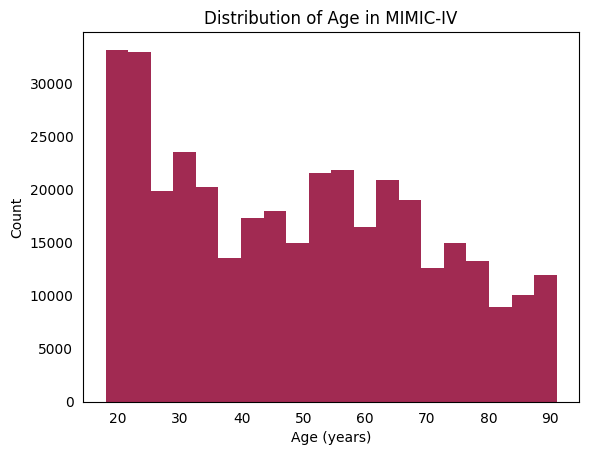

In [ ]:
# Checking the age distribution in patients' table

plt.hist(patients_df['anchor_age'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show()

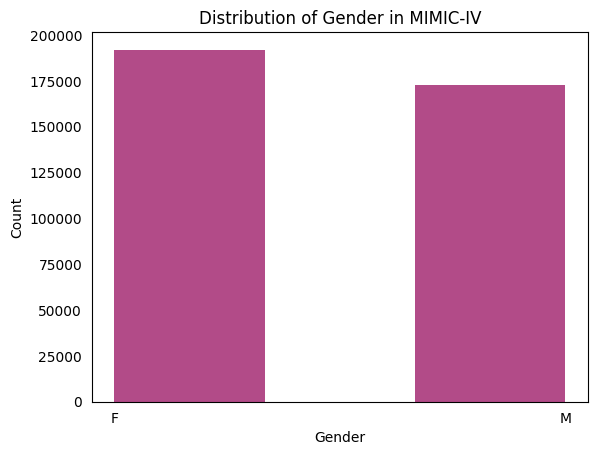

In [ ]:
# distribution of gender
plt.hist(patients_df['gender'], bins=3, color='#b24b88')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Distribution of Gender in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show()

### **Lab events Table**

In [ ]:
labevents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158374764 entries, 0 to 158374763
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   subject_id  int64         
 1   hadm_id     float64       
 2   itemid      int64         
 3   charttime   datetime64[ns]
 4   valuenum    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 5.9 GB


In [ ]:
# Joins labevents with icustays (on hadm_id) and with d_labitems to get lab labels.
# Filters for events in the first 24 hours, for specific lab itemids
# computes the average valuenum per stay_id per lab measurement
# finally pivots the result so that each column is a lab metric.

In [ ]:
# Defining the mapping for lab itemid to standard labels
lab_item_mapping = {
    '50862': 'Albumin',
    '50863': 'ALP',
    '50861': 'ALT',
    '50868': "Anion Gap",
    '50878': 'AST',
    '50882': "Bicarbonate",
    '50885': 'Bilirubin',
    '51842': 'BUN',
    '50902': "Chloride",
    '50912': "Creatinine",
    '50931': "Glucose",
    '50813': 'Lactate',
    '50954': 'LDH',
    '50960': "Magnesium",
    '50820': 'pH',
    '50971': "Potassium",
    '50983': "Sodium",
    '51006': "Urea Nitrogen",
    '51221': "Hematocrit",
    '51222': "Hemoglobin",
    '51248': "MCH",
    '51249': "MCHC",
    '51250': "MCV",
    '51265': "Platelet Count",
    '51277': "RDW",
    '51279': "Red Blood Cells",
    '51301': "White Blood Cells"
}


In [ ]:
valid_lab_items = list(lab_item_mapping.keys())
# Filter labevents for the desired itemids
labevents_df = labevents_df[labevents_df['itemid'].astype(str).isin(valid_lab_items)].copy()

# Merge with icustays on hadm_id to get ICU intime and stay_id
lab = pd.merge(labevents_df, icu_df[['hadm_id', 'stay_id', 'intime']], on='hadm_id', how='inner')

# Use the mapping defined above
lab['lab_metric'] = lab['itemid'].astype(str).map(lab_item_mapping)

# Compute time difference from ICU intime
lab['timediff'] = lab['charttime'] - lab['intime']

# Filter for labs measured after admission and within 24 hours
lab = lab[(lab['timediff'] > pd.Timedelta(0)) & (lab['timediff'] <= pd.Timedelta(hours=24))]

# Ensure valuenum is numeric
lab['valuenum'] = pd.to_numeric(lab['valuenum'], errors='coerce')
lab = lab[lab['valuenum'].notnull()]

# Group by stay_id and lab_metric and compute average valuenum
lab_avg = lab.groupby(['stay_id', 'lab_metric'])['valuenum'].mean().reset_index()

# Pivot the table so that each lab_metric becomes a column
lab_pivot = lab_avg.pivot(index='stay_id', columns='lab_metric', values='valuenum').reset_index()

<ipython-input-29-6a7b089f1265>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab['valuenum'] = pd.to_numeric(lab['valuenum'], errors='coerce')


In [ ]:
lab_pivot.head()

lab_metric,stay_id,ALP,ALT,AST,Albumin,Anion Gap,Bicarbonate,Bilirubin,Chloride,Creatinine,...,MCV,Magnesium,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Urea Nitrogen,White Blood Cells,pH
0,30000153,NaN,NaN,NaN,NaN,12.000000,21.000000,NaN,115.000000,1.000000,...,95.500000,1.850000,167.500000,4.600000,13.400000,3.185000,143.500000,22.000000,16.10,7.303333
1,30000213,97.0,12.0,19.0,NaN,15.666667,23.333333,0.30,100.666667,3.666667,...,84.000000,2.033333,226.000000,4.766667,16.500000,2.840000,139.666667,60.666667,5.80,7.405000
2,30000484,78.0,15.0,50.0,2.5,10.000000,27.000000,0.30,104.000000,1.200000,...,92.000000,2.300000,357.000000,5.300000,18.200000,2.670000,136.000000,47.000000,24.20,7.330000
3,30000646,97.0,22.0,19.0,NaN,12.333333,23.000000,0.70,109.333333,0.833333,...,88.666667,2.100000,290.333333,3.800000,15.233333,4.346667,140.666667,11.000000,9.00,7.440000
4,30000831,179.0,166.5,53.5,NaN,16.000000,25.000000,0.45,103.333333,2.200000,...,89.500000,2.500000,298.000000,3.800000,12.200000,4.400000,144.333333,70.000000,17.75,7.482500


In [ ]:
lab_pivot.shape

(87931, 27)

### **Chart events Table**

In [ ]:
chartevents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432997491 entries, 0 to 432997490
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   subject_id  int64         
 1   hadm_id     int64         
 2   stay_id     int64         
 3   charttime   datetime64[ns]
 4   itemid      int64         
 5   valuenum    float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 19.4 GB


In [ ]:
chartevents_df.head()

,subject_id,hadm_id,stay_id,charttime,itemid,valuenum
0,10000032,29079034,39553978,2180-07-23 12:36:00,226512,39.4
1,10000032,29079034,39553978,2180-07-23 12:36:00,226707,60.0
2,10000032,29079034,39553978,2180-07-23 12:36:00,226730,152.0
3,10000032,29079034,39553978,2180-07-23 14:00:00,220048,NaN
4,10000032,29079034,39553978,2180-07-23 14:00:00,224642,NaN


In [ ]:
# Joins chartevents with icustays to get ICU in-time,
# filters for events within 24 hours after ICU admission and for a set of specific itemids,
# then computes the average valuenum per stay_id per item
# Finally, the data is pivoted

In [ ]:
# Define the mapping for itemid to metric names
chart_item_mapping = {
    '220045': 'Heart_rate',
    '220210': 'Respiratory_rate',
    '220277': 'O2_saturation',
    '223761': 'Temperature_F',
    '220739': 'GCS_eye',
    '223900': 'GCS_verbal',
    '223901': 'GCS_motor',
    '220224': 'PO2_arterial',
    '220235': 'PCO2_arterial',
    '223835': 'FiO2'
}

In [ ]:
# Filter chartevents for only relevant itemids
valid_items = list(chart_item_mapping.keys())
chartevents_df = chartevents_df[chartevents_df['itemid'].astype(str).isin(valid_items)].copy()

# Merge with icustays to get ICU intime
chart = pd.merge(chartevents_df, icu_df[['stay_id', 'intime']], on='stay_id', how='inner')

# Compute time difference in hours
chart['timediff'] = (chart['charttime'] - chart['intime'])
# Filter for events after admission and within 24 hours
chart = chart[(chart['timediff'] > pd.Timedelta(0)) & (chart['timediff'] <= pd.Timedelta(hours=24))]

# Ensure 'valuenum' is numeric
chart['valuenum'] = pd.to_numeric(chart['valuenum'], errors='coerce')
# Also, drop rows where value is null
chart = chart[chart['valuenum'].notnull()]

# Group by stay_id and itemid, computing the average of valuenum
chart_avg = chart.groupby(['stay_id', 'itemid'])['valuenum'].mean().reset_index()

# Map itemid to metric names
chart_avg['metric'] = chart_avg['itemid'].astype(str).map(chart_item_mapping)

# Pivot: index=stay_id, columns=metric, values=average value
chart_pivot = chart_avg.pivot(index='stay_id', columns='metric', values='valuenum').reset_index()

<ipython-input-36-3242ef3c37dd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart['valuenum'] = pd.to_numeric(chart['valuenum'], errors='coerce')


In [ ]:
chart_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89913 entries, 0 to 89912
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stay_id           89913 non-null  int64  
 1   FiO2              41410 non-null  float64
 2   GCS_eye           89452 non-null  float64
 3   GCS_motor         89423 non-null  float64
 4   GCS_verbal        89431 non-null  float64
 5   Heart_rate        89858 non-null  float64
 6   O2_saturation     89734 non-null  float64
 7   PCO2_arterial     35268 non-null  float64
 8   PO2_arterial      35274 non-null  float64
 9   Respiratory_rate  89667 non-null  float64
 10  Temperature_F     84255 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 7.5 MB


In [ ]:
chart_pivot.head()

metric,stay_id,FiO2,GCS_eye,GCS_motor,GCS_verbal,Heart_rate,O2_saturation,PCO2_arterial,PO2_arterial,Respiratory_rate,Temperature_F
0,30000153,46.250000,3.312500,5.812500,3.187500,106.840000,96.640000,44.0,233.0,14.960000,99.500000
1,30000213,47.142857,3.714286,5.714286,3.571429,81.680000,98.960000,NaN,NaN,19.080000,98.612500
2,30000484,NaN,3.600000,3.000000,1.000000,89.958333,99.791667,NaN,NaN,14.708333,96.642857
3,30000646,100.000000,4.000000,6.000000,5.000000,86.423729,95.610169,30.0,71.0,25.627119,99.275000
4,30000831,76.250000,3.428571,5.142857,2.428571,99.533333,94.533333,NaN,NaN,26.622222,99.577778


In [ ]:
chart_pivot.shape

(89913, 11)

### **Diagnosis_icd Table**

**Extracting Comorbidity Information data and common diagnosis data from diagnosis_icd table**

In [ ]:
diagnosis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364488 entries, 0 to 6364487
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 242.8+ MB


In [ ]:
# Define mappings using code prefixes and ranges
def categorize_icd_code(icd_code, version):
    icd_code = icd_code.replace('.', '')  # remove dot if any
    if version == 9:
        if icd_code.startswith(('042', '07953', '79571')): return 'AIDS'
        if icd_code.startswith(('204', '205', '206', '207', '208', '280', '281', '282', '283', '284', '285', '287')): return 'Hematological diseases'
        if icd_code.startswith('428'): return 'Heart failure'
        if icd_code.startswith(('200', '201', '202')): return 'Lymphoma'
        if icd_code.startswith(('51881', '51882')): return 'Respiratory failure'
        if icd_code[:3] in ['196', '197', '198', '199']: return 'Metastasis'
        if icd_code.startswith(('279', 'V42', 'V58', 'V87')): return 'Immunosuppression'
        if icd_code.startswith('570'): return 'Liver failure'
        if icd_code.startswith(('5712', '5715', '5716')): return 'Cirrhosis'
        if icd_code.startswith(('V45', 'V56')): return 'Dialysis'
        if icd_code.startswith(('038', '99591', '99592')): return 'Sepsis/Septic shock'
        if icd_code.startswith(('4275', '7981')): return 'Post cardiac arrest syndrome'
        if icd_code[:3] in ['433', '434', '435', '436', '437', '438']: return 'Stroke'
        if icd_code[:3] in ['410', '411']: return 'Acute coronary syndrome'
        if icd_code[:3].isdigit() and 800 <= int(icd_code[:3]) <= 959: return 'Trauma'

    elif version == 10:
        if icd_code.startswith(('B20', 'B9735', 'Z21')): return 'AIDS'
        if icd_code[:3] in ['C91', 'C92', 'C93', 'C94', 'C95', 'D50', 'D51', 'D52', 'D53', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60', 'D61', 'D63', 'D64']: return 'Hematological diseases'
        if icd_code.startswith('I50'): return 'Heart failure'
        if icd_code[:3] in ['C81', 'C82', 'C83', 'C84', 'C85']: return 'Lymphoma'
        if icd_code.startswith('J96'): return 'Respiratory failure'
        if icd_code[:3] in ['C77', 'C78', 'C79']: return 'Metastasis'
        if icd_code.startswith(('Z94', 'Z92', 'D80', 'D81', 'D82', 'D83', 'D84')): return 'Immunosuppression'
        if icd_code.startswith('K72'): return 'Liver failure'
        if icd_code.startswith('K74'): return 'Cirrhosis'
        if icd_code.startswith(('Z49', 'Z99')): return 'Dialysis'
        if icd_code[:3] in ['A40', 'A41'] or icd_code.startswith(('R6520', 'R6521')): return 'Sepsis/Septic shock'
        if icd_code.startswith(('I46', 'I97121')): return 'Post cardiac arrest syndrome'
        if icd_code.startswith(('I63', 'I64', 'G45')): return 'Stroke'
        if icd_code[:3] in ['I20', 'I21', 'I22']: return 'Acute coronary syndrome'
        if icd_code[0] in ['S', 'T']: return 'Trauma'
    return None

# Apply the mapping
diagnosis_df['clinical_category'] = diagnosis_df.apply(lambda row: categorize_icd_code(row['icd_code'], row['icd_version']), axis=1)


In [ ]:
# Delete rows where clinical_category =  None
diagnosis_df = diagnosis_df.dropna(subset=['clinical_category'])
diagnosis_df.shape

(841798, 6)

In [ ]:
diagnosis_df['clinical_category'].value_counts()

,count
clinical_category,
Trauma,175087
Hematological diseases,151367
Heart failure,112936
Immunosuppression,104935
Dialysis,83336
Metastasis,52923
Sepsis/Septic shock,38493
Respiratory failure,30947
Stroke,26345


In [ ]:
# Create a pivot table (binary indicator for each comorbidity per patient)
#binary_diag_df = pd.crosstab(diagnosis_df['hadm_id'], diagnosis_df['clinical_category']).reset_index()
binary_diag_df = pd.crosstab(
                    diagnosis_df['hadm_id'],
                    diagnosis_df['clinical_category']
                ).gt(0).astype(int).reset_index()

binary_diag_df.head()

clinical_category,hadm_id,AIDS,Acute coronary syndrome,Cirrhosis,Dialysis,Heart failure,Hematological diseases,Immunosuppression,Liver failure,Lymphoma,Metastasis,Post cardiac arrest syndrome,Respiratory failure,Sepsis/Septic shock,Stroke,Trauma
0,20000019,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,20000024,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,20000034,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,20000041,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,20000045,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0


In [ ]:
binary_diag_df.shape

(334439, 16)

In [ ]:
binary_diag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334439 entries, 0 to 334438
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   hadm_id                       334439 non-null  int64
 1   AIDS                          334439 non-null  int64
 2   Acute coronary syndrome       334439 non-null  int64
 3   Cirrhosis                     334439 non-null  int64
 4   Dialysis                      334439 non-null  int64
 5   Heart failure                 334439 non-null  int64
 6   Hematological diseases        334439 non-null  int64
 7   Immunosuppression             334439 non-null  int64
 8   Liver failure                 334439 non-null  int64
 9   Lymphoma                      334439 non-null  int64
 10  Metastasis                    334439 non-null  int64
 11  Post cardiac arrest syndrome  334439 non-null  int64
 12  Respiratory failure           334439 non-null  int64
 13  Sepsis/Septic 

## **Data Merging :** Merging datasets into a single dataframe

In [ ]:
icu_df.shape

(89952, 7)

In [ ]:
# Merge icustays with admissions on hadm_id
merged_df = pd.merge(icu_df, admissions_df, on=['hadm_id','subject_id'], how='inner')
merged_df.shape

(89952, 12)

In [ ]:
# Merge with patients on subject_id
merged_df = pd.merge(merged_df, patients_df, on='subject_id', how='inner')
merged_df.shape

(89952, 14)

In [ ]:
# Merge with chart_data and lab_data on stay_id
merged_df = pd.merge(merged_df, chart_pivot, on='stay_id', how='inner')
merged_df = pd.merge(merged_df, lab_pivot, on='stay_id', how='inner')
merged_df.shape

(87893, 50)

In [ ]:
# Merge diagnosis data
merged_df = pd.merge(merged_df, binary_diag_df, on='hadm_id', how='left')
merged_df.shape

(87893, 65)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87893 entries, 0 to 87892
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   subject_id                    87893 non-null  int64         
 1   hadm_id                       87893 non-null  int64         
 2   stay_id                       87893 non-null  int64         
 3   first_careunit                87893 non-null  object        
 4   intime                        87893 non-null  datetime64[ns]
 5   outtime                       87893 non-null  datetime64[ns]
 6   los                           87893 non-null  float64       
 7   deathtime                     10031 non-null  datetime64[ns]
 8   admission_type                87893 non-null  object        
 9   admission_location            87893 non-null  object        
 10  race                          87893 non-null  object        
 11  hospital_expire_flag        

In [ ]:
merged_df.head(5)

,subject_id,hadm_id,stay_id,first_careunit,intime,outtime,los,deathtime,admission_type,admission_location,...,Hematological diseases,Immunosuppression,Liver failure,Lymphoma,Metastasis,Post cardiac arrest syndrome,Respiratory failure,Sepsis/Septic shock,Stroke,Trauma
0,10000032,29079034,39553978,Medical ICU,2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,NaT,Emergency,Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000690,25860671,37081114,Medical ICU,2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,NaT,Emergency,Emergency,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10000980,26913865,39765666,Medical ICU,2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,NaT,Emergency,Emergency,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10001217,24597018,37067082,Surgical ICU,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,NaT,Emergency,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001217,27703517,34592300,Surgical ICU,2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,NaT,Emergency,Referral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Data Pre-processing :**

In [ ]:
# Check duplicates
merged_df.duplicated().sum()

np.int64(0)

In [ ]:
# Filter on length of stay (los); where los > 1
merged_df = merged_df[merged_df['los'] > 1]

In [ ]:
# Data Cleaning rules

merged_df = merged_df[
    (merged_df["anchor_age"] >= 18) & (merged_df["anchor_age"] <= 90) &
    (merged_df["Heart_rate"] >= 25) & (merged_df["Heart_rate"] <= 225) &
    (merged_df["Respiratory_rate"] > 7) & (merged_df["Respiratory_rate"] < 40) &
    (merged_df["O2_saturation"] > 50) & (merged_df["O2_saturation"] < 120) &
    (merged_df["Temperature_F"] >= 86) & (merged_df["Temperature_F"] <= 113)
]
merged_df.shape

(62971, 65)

In [ ]:
# Conversion from float to int: for clinical_category columns

columns_to_convert = [
    "AIDS",
    "Acute coronary syndrome",
    "Cirrhosis",
    "Dialysis",
    "Heart failure",
    "Hematological diseases",
    "Immunosuppression",
    "Liver failure",
    "Lymphoma",
    "Metastasis",
    "Post cardiac arrest syndrome",
    "Respiratory failure",
    "Sepsis/Septic shock",
    "Stroke",
    "Trauma"
]
# Replace NaN with 0 and convert to int
merged_df[columns_to_convert] = merged_df[columns_to_convert].fillna(0).astype(int)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62971 entries, 1 to 87892
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   subject_id                    62971 non-null  int64         
 1   hadm_id                       62971 non-null  int64         
 2   stay_id                       62971 non-null  int64         
 3   first_careunit                62971 non-null  object        
 4   intime                        62971 non-null  datetime64[ns]
 5   outtime                       62971 non-null  datetime64[ns]
 6   los                           62971 non-null  float64       
 7   deathtime                     7135 non-null   datetime64[ns]
 8   admission_type                62971 non-null  object        
 9   admission_location            62971 non-null  object        
 10  race                          62971 non-null  object        
 11  hospital_expire_flag          629

In [ ]:
merged_df.head()

,subject_id,hadm_id,stay_id,first_careunit,intime,outtime,los,deathtime,admission_type,admission_location,...,Hematological diseases,Immunosuppression,Liver failure,Lymphoma,Metastasis,Post cardiac arrest syndrome,Respiratory failure,Sepsis/Septic shock,Stroke,Trauma
1,10000690,25860671,37081114,Medical ICU,2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,NaT,Emergency,Emergency,...,1,0,0,0,0,0,1,0,0,0
3,10001217,24597018,37067082,Surgical ICU,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,NaT,Emergency,Emergency,...,0,0,0,0,0,0,0,0,0,0
5,10001725,25563031,31205490,Medical ICU,2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,NaT,Emergency,Internal Transfer,...,0,0,0,0,0,0,0,0,0,0
8,10002013,23581541,39060235,Cardiac ICU,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,NaT,Elective,Referral,...,0,0,0,0,0,0,0,0,0,0
9,10002114,27793700,34672098,Cardiac ICU,2162-02-17 23:30:00,2162-02-20 21:16:27,2.907257,NaT,Observation,Referral,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Dropping columns subject id, hadm_id, stay_id, intime	, outtime
df_cleaned = merged_df.drop(columns=['subject_id', 'hadm_id', 'stay_id','intime','outtime','deathtime'])

In [ ]:
df_cleaned.shape

(62971, 59)

In [ ]:
df_cleaned.isnull().sum().sort_values(ascending=False)

,0
LDH,44038
Albumin,44005
PCO2_arterial,36203
PO2_arterial,36198
Bilirubin,33312
ALP,33223
ALT,33147
AST,32863
FiO2,31601
Lactate,26766


In [ ]:
null_percentage = df_cleaned.isnull().mean() * 100
null_percentage.sort_values(ascending=False)

,0
LDH,69.933779
Albumin,69.881374
PCO2_arterial,57.491544
PO2_arterial,57.483604
Bilirubin,52.900542
ALP,52.759207
ALT,52.638516
AST,52.187515
FiO2,50.183418
Lactate,42.505280


In [ ]:
# Deleting columns with more than 50% missing values

columns_to_drop = null_percentage[null_percentage > 50].index
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62971 entries, 1 to 87892
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   first_careunit                62971 non-null  object 
 1   los                           62971 non-null  float64
 2   admission_type                62971 non-null  object 
 3   admission_location            62971 non-null  object 
 4   race                          62971 non-null  object 
 5   hospital_expire_flag          62971 non-null  int64  
 6   gender                        62971 non-null  object 
 7   anchor_age                    62971 non-null  int64  
 8   GCS_eye                       62957 non-null  float64
 9   GCS_motor                     62944 non-null  float64
 10  GCS_verbal                    62946 non-null  float64
 11  Heart_rate                    62971 non-null  float64
 12  O2_saturation                 62971 non-null  float64
 13  Respir

In [ ]:
df_cleaned.shape

(62971, 50)

**Handling Missing values**

In [ ]:
# Select only missing numeric features for imputation
# select only columns of float data types
numeric_columns = df_cleaned.select_dtypes(include=['float']).columns
#numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['los', 'GCS_eye', 'GCS_motor', 'GCS_verbal', 'Heart_rate',
       'O2_saturation', 'Respiratory_rate', 'Temperature_F', 'Anion Gap',
       'Bicarbonate', 'Chloride', 'Creatinine', 'Glucose', 'Hematocrit',
       'Hemoglobin', 'Lactate', 'MCH', 'MCHC', 'MCV', 'Magnesium',
       'Platelet Count', 'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
       'Urea Nitrogen', 'White Blood Cells', 'pH'],
      dtype='object')

In [ ]:
imputer = IterativeImputer(random_state=42, max_iter=10)
# Fit the imputer and transform the numeric columns
df_cleaned[numeric_columns] = imputer.fit_transform(df_cleaned[numeric_columns])

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62971 entries, 1 to 87892
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   first_careunit                62971 non-null  object 
 1   los                           62971 non-null  float64
 2   admission_type                62971 non-null  object 
 3   admission_location            62971 non-null  object 
 4   race                          62971 non-null  object 
 5   hospital_expire_flag          62971 non-null  int64  
 6   gender                        62971 non-null  object 
 7   anchor_age                    62971 non-null  int64  
 8   GCS_eye                       62971 non-null  float64
 9   GCS_motor                     62971 non-null  float64
 10  GCS_verbal                    62971 non-null  float64
 11  Heart_rate                    62971 non-null  float64
 12  O2_saturation                 62971 non-null  float64
 13  Respir

## **Visualization**

In [ ]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
comorbidity_cols = ['AIDS', 'Acute coronary syndrome', 'Cirrhosis', 'Dialysis', 'Heart failure',
               'Hematological diseases', 'Immunosuppression', 'Liver failure', 'Lymphoma', 'Metastasis',
               'Post cardiac arrest syndrome', 'Respiratory failure', 'Sepsis/Septic shock', 'Stroke', 'Trauma']
# Select all numeric columns
all_num_cols = df_cleaned.select_dtypes(include='number').columns
# Exclude comorbidity columns
numerical_cols = [col for col in all_num_cols if col not in comorbidity_cols]

### **Univariate Analysis**

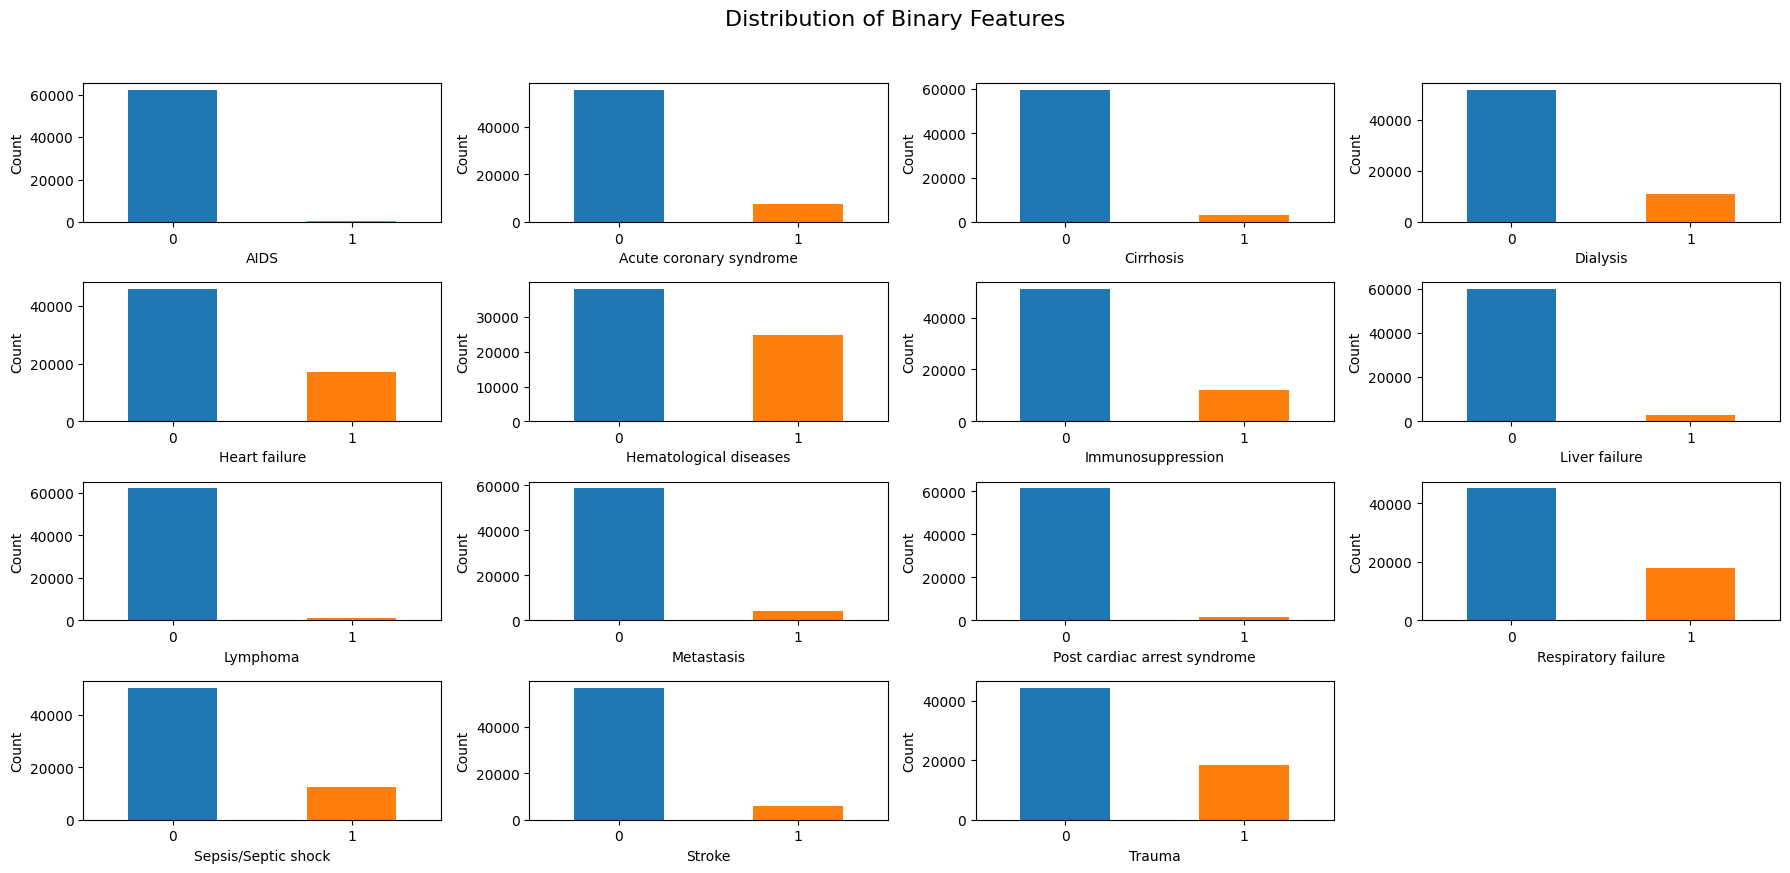

In [ ]:
# Set up the plot grid
n_cols = 4
n_rows = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e']  # Blue for 0, Orange for 1
# Plot distribution for each binary column
for i, col in enumerate(comorbidity_cols):
    df_cleaned[col].value_counts(dropna=False).sort_index().plot(kind='bar', ax=axes[i], color=colors)
    axes[i].set_xticks(range(len(df_cleaned[col].value_counts(dropna=False).index)))
    axes[i].set_xticklabels([str(x) for x in df_cleaned[col].value_counts(dropna=False).index], rotation=0)
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle('Distribution of Binary Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

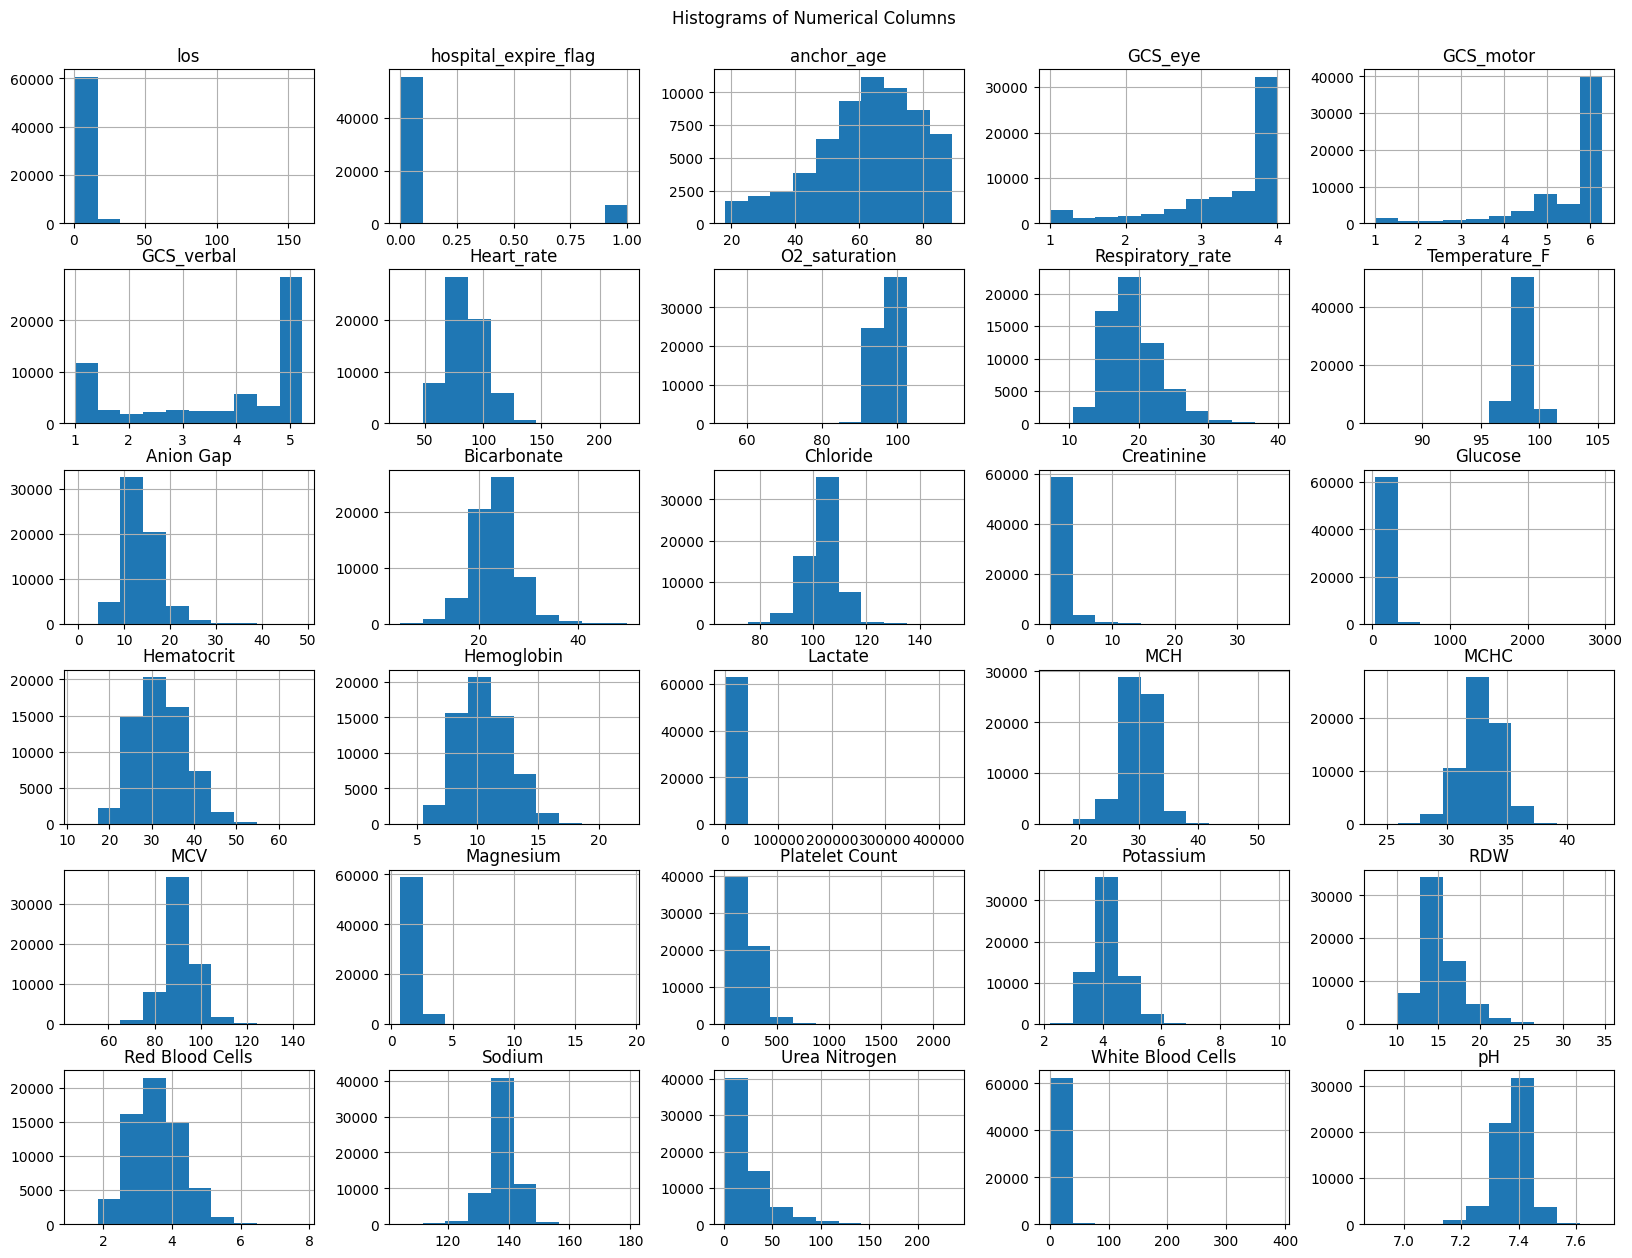

In [ ]:
# Plot histograms for numerical columns
df_cleaned[numerical_cols].hist(figsize=(20, 15))
plt.suptitle('Histograms of Numerical Columns', y=0.92)
plt.show()

### **Bivariate Analysis**

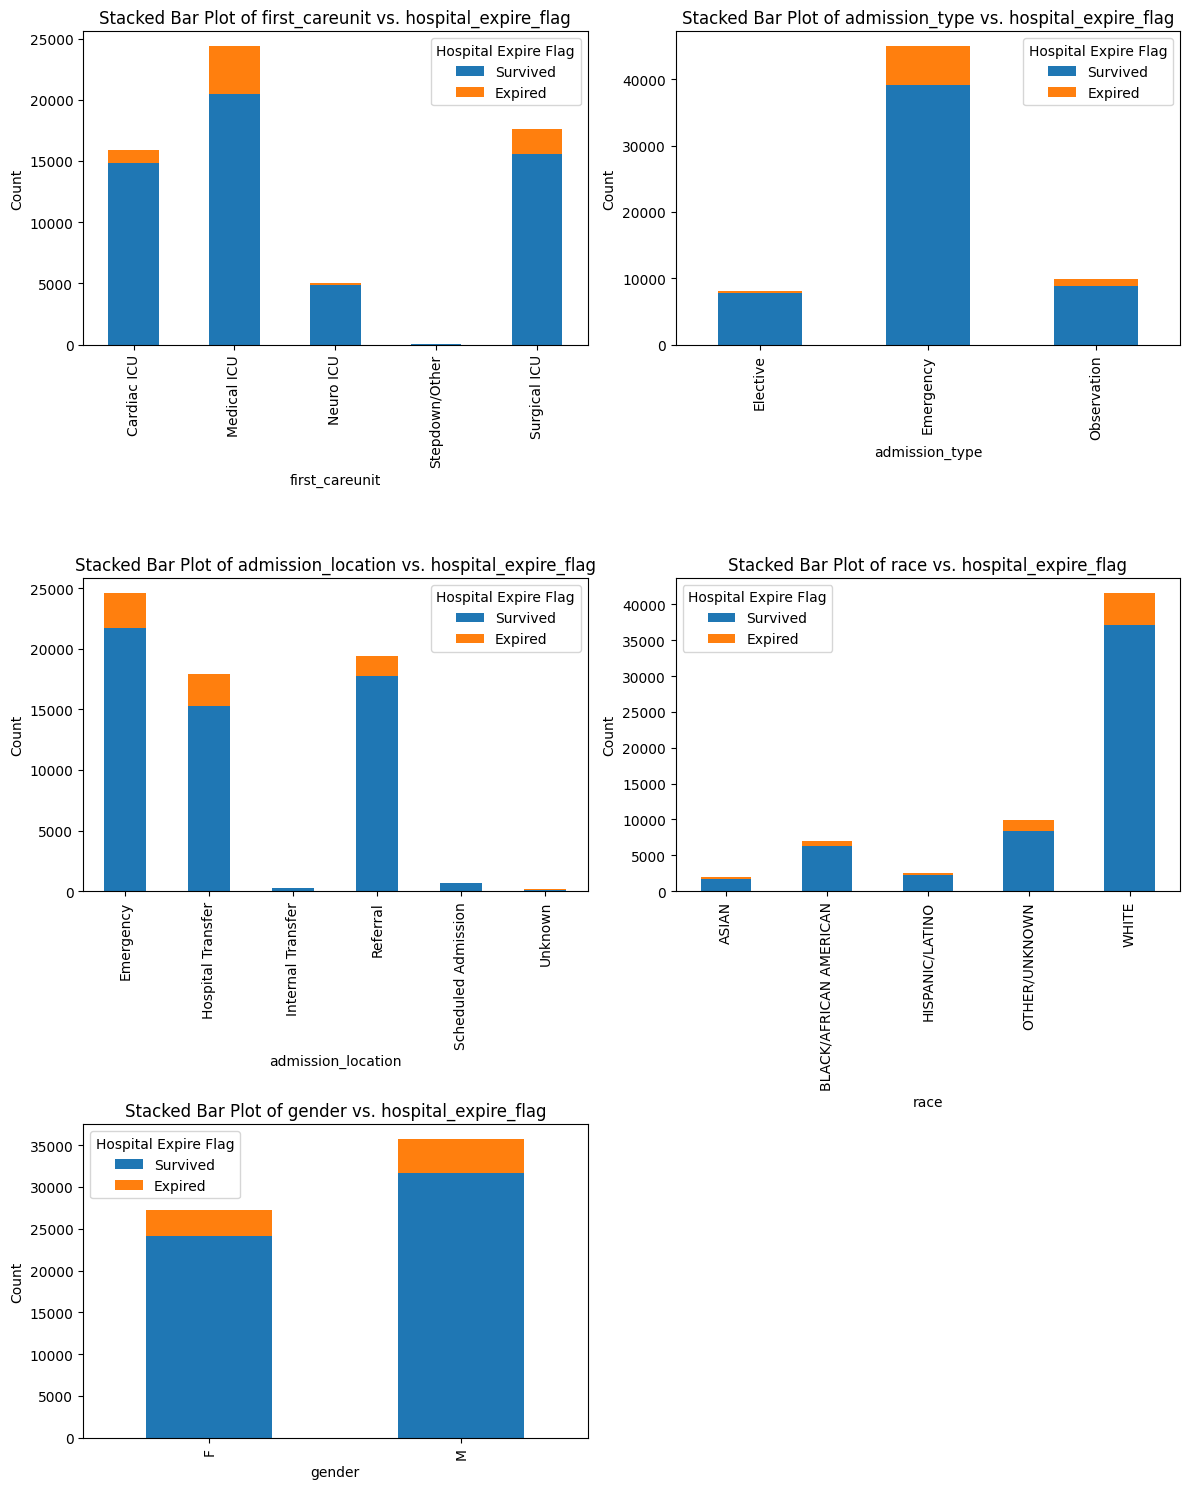

In [ ]:
# Stacked bar plots for categorical columns vs. hospital_expiry_flag

plots_per_row = 2
num_cols = len(categorical_cols)
num_rows = (num_cols + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 6, num_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    cross_tab = pd.crosstab(df_cleaned[col], df_cleaned['hospital_expire_flag'])
    cross_tab.plot(kind='bar', stacked=True, ax=axes[idx])
    axes[idx].set_title(f'Stacked Bar Plot of {col} vs. hospital_expire_flag')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].legend(title='Hospital Expire Flag', labels=['Survived', 'Expired'])

for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

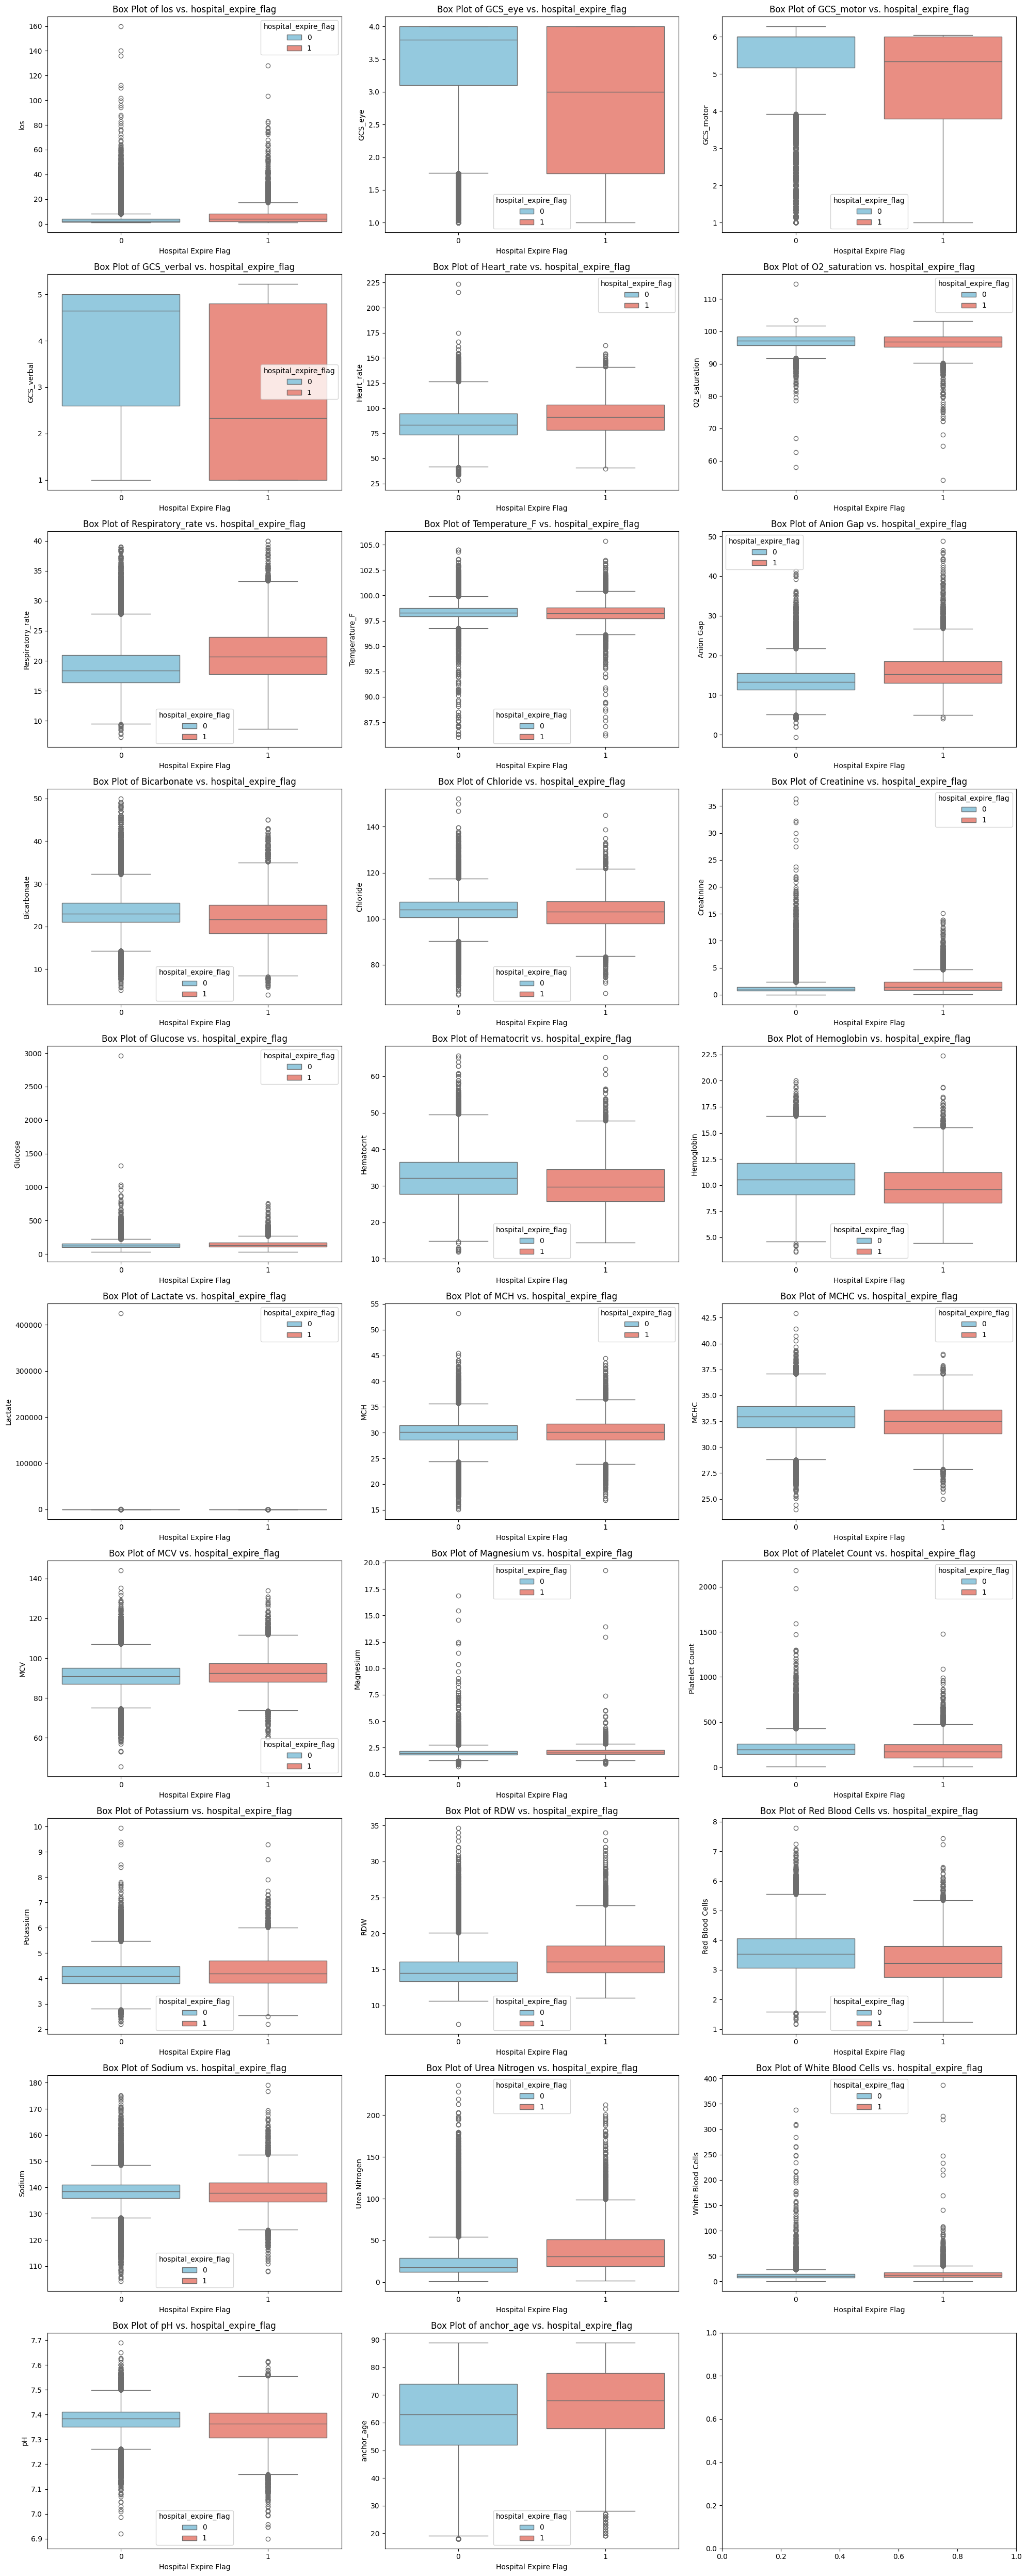

In [ ]:
# Box plots for numerical columns vs. hospital_expiry_flag

num_cols = len(numerical_cols)
cols =3
rows = math.ceil(num_cols / cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))

for i, col in enumerate(numerical_cols):
    row_index = i // cols
    col_index = i % cols
    ax = axes[row_index, col_index]

    sns.boxplot(x='hospital_expire_flag', y=col, data=df_cleaned,ax=ax, hue='hospital_expire_flag', palette={0: 'skyblue', 1: 'salmon'})
    ax.set_title(f'Box Plot of {col} vs. hospital_expire_flag')
    ax.set_xlabel('Hospital Expire Flag')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

### **Exploratory Analysis**

In [ ]:
# Creating a copy of processed df
df_eda = df_cleaned.copy(deep=True)

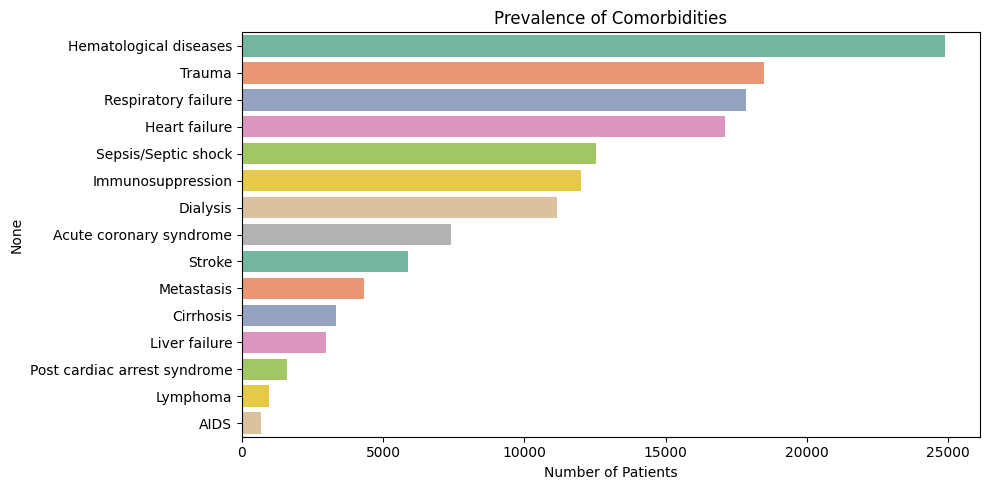

In [ ]:
# Prevalence of Comorbidities in the dataset

comorbidities = comorbidity_cols

comorbidity_sum = df_eda[comorbidities].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=comorbidity_sum.values, y=comorbidity_sum.index, hue=comorbidity_sum.index, palette='Set2', legend=False)
plt.title('Prevalence of Comorbidities')
plt.xlabel('Number of Patients')
plt.tight_layout()
plt.show()

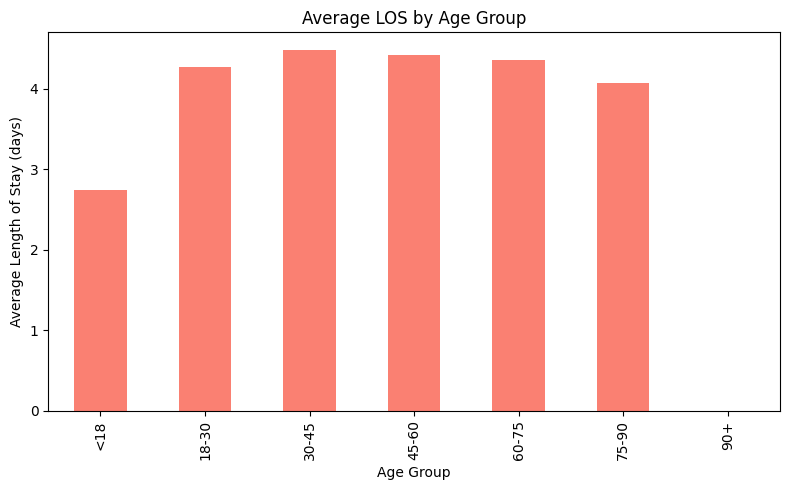

In [ ]:
# Analyzing Length of Stay by Age group

# Bin ages into groups
bins = [0, 18, 30, 45, 60, 75, 90, 120]
labels = ['<18', '18-30', '30-45', '45-60', '60-75', '75-90', '90+']
df_eda['age_group'] = pd.cut(df_eda['anchor_age'], bins=bins, labels=labels)

# Plot average LOS by age group
age_los = df_eda.groupby('age_group',observed=False)['los'].mean()

age_los.plot(kind='bar', color='salmon', figsize=(8, 5))
plt.title('Average LOS by Age Group')
plt.ylabel('Average Length of Stay (days)')
plt.xlabel('Age Group')
plt.tight_layout()
plt.show()

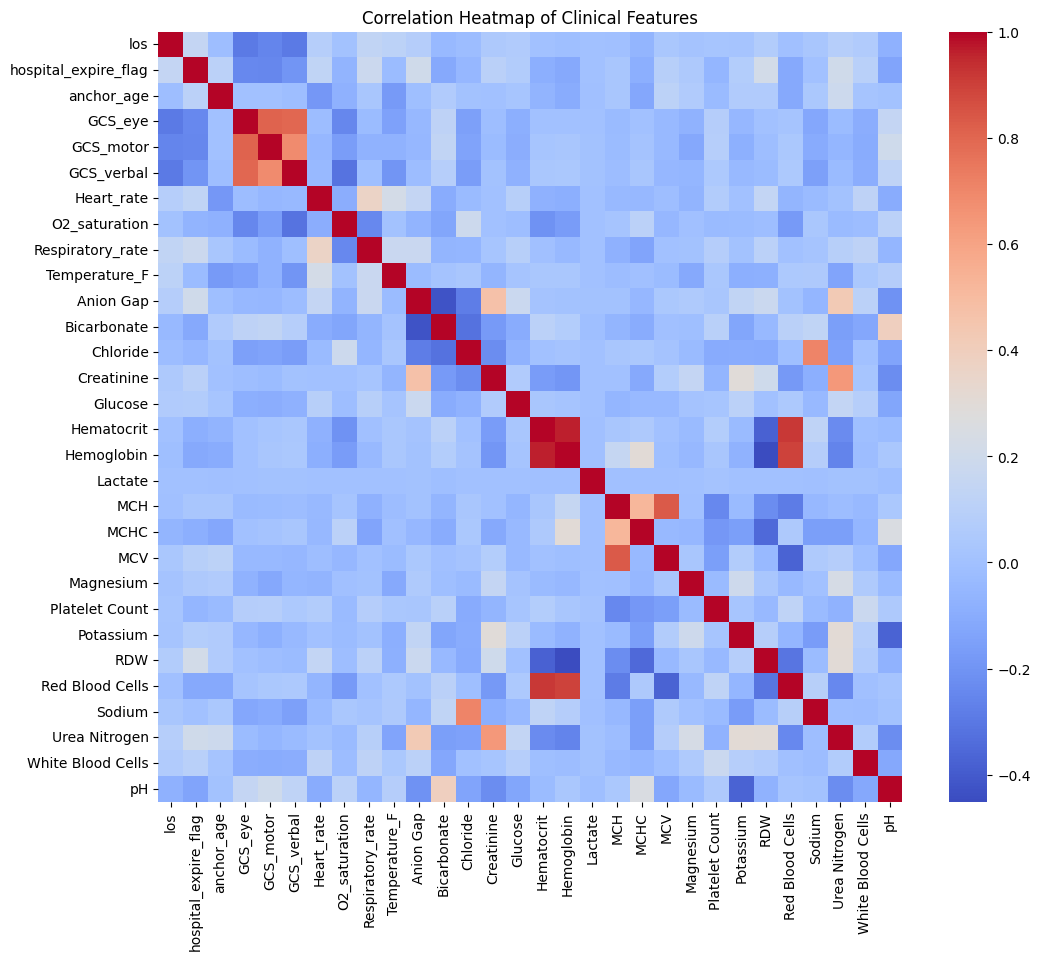

In [ ]:
# Heatmap for clnical features

plt.figure(figsize=(12, 10))
#num_cols = df_eda.select_dtypes(include='number').columns
corr = df_eda[numerical_cols].corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Heatmap of Clinical Features')
plt.show()

## **Data Preparation**

In [ ]:
# Converting gender to int
df_cleaned['gender'].value_counts()

,count
gender,
M,35699
F,27272


In [ ]:
gender_map = {
    "M": 0,
    "F": 1
}

df_cleaned["gender"] = df_cleaned["gender"].map(gender_map)

In [ ]:
# Convert categorical variables to dummies

# select columns of type object
categorical_columns = merged_df.select_dtypes(include=['object']).columns.tolist()
# Create dummies
final_analyzed_df = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

In [ ]:
final_analyzed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62971 entries, 1 to 87892
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   los                                     62971 non-null  float64
 1   hospital_expire_flag                    62971 non-null  int64  
 2   anchor_age                              62971 non-null  int64  
 3   GCS_eye                                 62971 non-null  float64
 4   GCS_motor                               62971 non-null  float64
 5   GCS_verbal                              62971 non-null  float64
 6   Heart_rate                              62971 non-null  float64
 7   O2_saturation                           62971 non-null  float64
 8   Respiratory_rate                        62971 non-null  float64
 9   Temperature_F                           62971 non-null  float64
 10  Anion Gap                               62971 non-null  float64

In [ ]:
#final_analyzed_df.to_csv('final_analyzed_df.csv', index=False)

## **Classification Modelling - for ICU Mortality Prediction**

<ipython-input-109-55815aa6f7d5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_analyzed_df, x='hospital_expire_flag', palette='viridis')


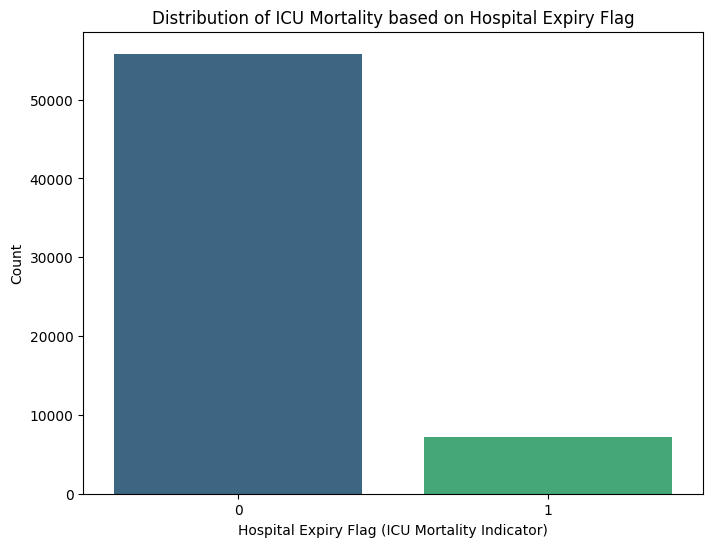

In [ ]:
counts = final_analyzed_df['hospital_expire_flag'].value_counts()

# Plot the distribution using seaborn's countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=final_analyzed_df, x='hospital_expire_flag', palette='viridis')
plt.xlabel('Hospital Expiry Flag (ICU Mortality Indicator)')
plt.ylabel('Count')
plt.title('Distribution of ICU Mortality based on Hospital Expiry Flag')
plt.show()

### **Data Splitting**

**Split Data: Into Target and Feature**

In [ ]:
# For classification :ICU Mortality prediction
target_clf = 'hospital_expire_flag'

# Drop target columns from features
features_clf = final_analyzed_df.drop(columns=[target_clf])

X_clf = features_clf

# Define targets for each task
y_clf = final_analyzed_df[target_clf]

**Split Data: Into Training and Test sets**

In [ ]:
# For classification
# Using 90:10 ratio for training and test set (since we will downsample training data to maintain class balance)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.1, random_state=42)

In [ ]:
# print shape of training set and test set for classification
print(f"Classification train shape: {X_clf_train.shape}")
print(f"Classification test shape: {X_clf_test.shape}")

Classification train shape: (56673, 60)
Classification test shape: (6298, 60)


In [ ]:
# Checking Class distribution of response variable in training set for clasification

train_sizes = [500, 1000, 1500, 2000, 2500, len(y_clf)]
for size in train_sizes:
    y_subset = y_clf[:size]
    print(f"Training size: {size}, Class distribution: {np.bincount(y_subset)}")

Training size: 500, Class distribution: [436  64]
Training size: 1000, Class distribution: [882 118]
Training size: 1500, Class distribution: [1321  179]
Training size: 2000, Class distribution: [1765  235]
Training size: 2500, Class distribution: [2213  287]
Training size: 62971, Class distribution: [55830  7141]


### **Handle Class Imabalance for Classification**

<ipython-input-114-99dedf70a8df>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_clf_train, palette='viridis')


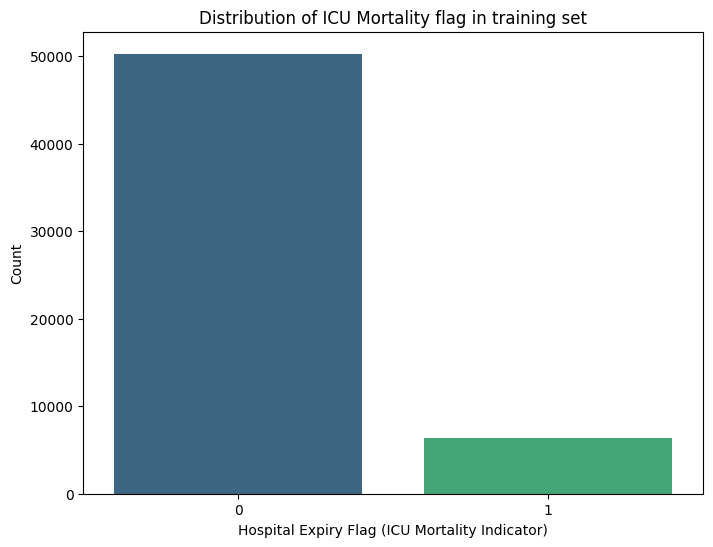

In [ ]:
counts = y_clf_train.value_counts()

# Plot the distribution using seaborn's countplot
plt.figure(figsize=(8, 6))
sns.countplot(x=y_clf_train, palette='viridis')
plt.xlabel('Hospital Expiry Flag (ICU Mortality Indicator)')
plt.ylabel('Count')
plt.title('Distribution of ICU Mortality flag in training set')
plt.show()

In [ ]:
# Downsample the majority class in the training set
rus = RandomUnderSampler(random_state=42)
X_clf_train_down, y_clf_train_down = rus.fit_resample(X_clf_train, y_clf_train)

print("After downsampling, class distribution:")
print(pd.Series(y_clf_train_down).value_counts())

After downsampling, class distribution:
hospital_expire_flag
0    6414
1    6414
Name: count, dtype: int64


<ipython-input-116-af2466e65569>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_clf_train_down, palette='viridis')


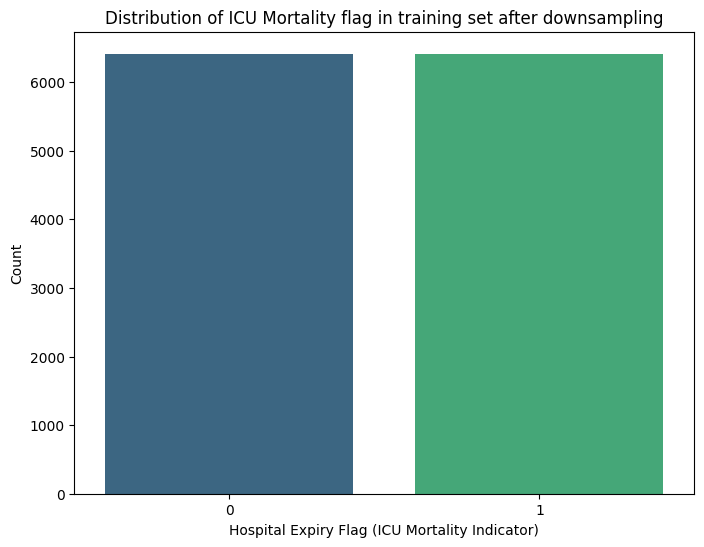

In [ ]:
# Plot the distribution using seaborn's countplot
plt.figure(figsize=(8, 6))
sns.countplot(x=y_clf_train_down, palette='viridis')
plt.xlabel('Hospital Expiry Flag (ICU Mortality Indicator)')
plt.ylabel('Count')
plt.title('Distribution of ICU Mortality flag in training set after downsampling')
plt.show()

### **Feature Selection using RandomForest for Classification**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf_model.fit(X_clf, y_clf)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their coefficients
feature_imp_df = pd.DataFrame({
    'Feature': X_clf_train_down.columns,
    'Score': importances
})
# Display all features with coefficients
print(feature_imp_df.sort_values(by='Score', ascending=False))

                                   Feature     Score
40                     Respiratory failure  0.065258
26                           Urea Nitrogen  0.050123
2                                  GCS_eye  0.049702
0                                      los  0.049484
23                                     RDW  0.047200
41                     Sepsis/Septic shock  0.042495
4                               GCS_verbal  0.037293
7                         Respiratory_rate  0.037022
3                                GCS_motor  0.034585
1                               anchor_age  0.033333
12                              Creatinine  0.029297
9                                Anion Gap  0.029124
5                               Heart_rate  0.026369
21                          Platelet Count  0.026180
8                            Temperature_F  0.025551
28                                      pH  0.024906
6                            O2_saturation  0.023820
16                                 Lactate  0.

In [ ]:
# Taking a threshold of 0.01 for score value
threshold = 0.01
selected_features = feature_imp_df[feature_imp_df['Score'] > threshold]
selected_features = selected_features.sort_values(by='Score', ascending=False).reset_index(drop=True)

print("Selected features using Random Forest:")
print(selected_features)

Selected features using Random Forest:
                         Feature     Score
0            Respiratory failure  0.065258
1                  Urea Nitrogen  0.050123
2                        GCS_eye  0.049702
3                            los  0.049484
4                            RDW  0.047200
5            Sepsis/Septic shock  0.042495
6                     GCS_verbal  0.037293
7               Respiratory_rate  0.037022
8                      GCS_motor  0.034585
9                     anchor_age  0.033333
10                    Creatinine  0.029297
11                     Anion Gap  0.029124
12                    Heart_rate  0.026369
13                Platelet Count  0.026180
14                 Temperature_F  0.025551
15                            pH  0.024906
16                 O2_saturation  0.023820
17                       Lactate  0.023578
18             White Blood Cells  0.023077
19                   Bicarbonate  0.022547
20               Red Blood Cells  0.021332
21             

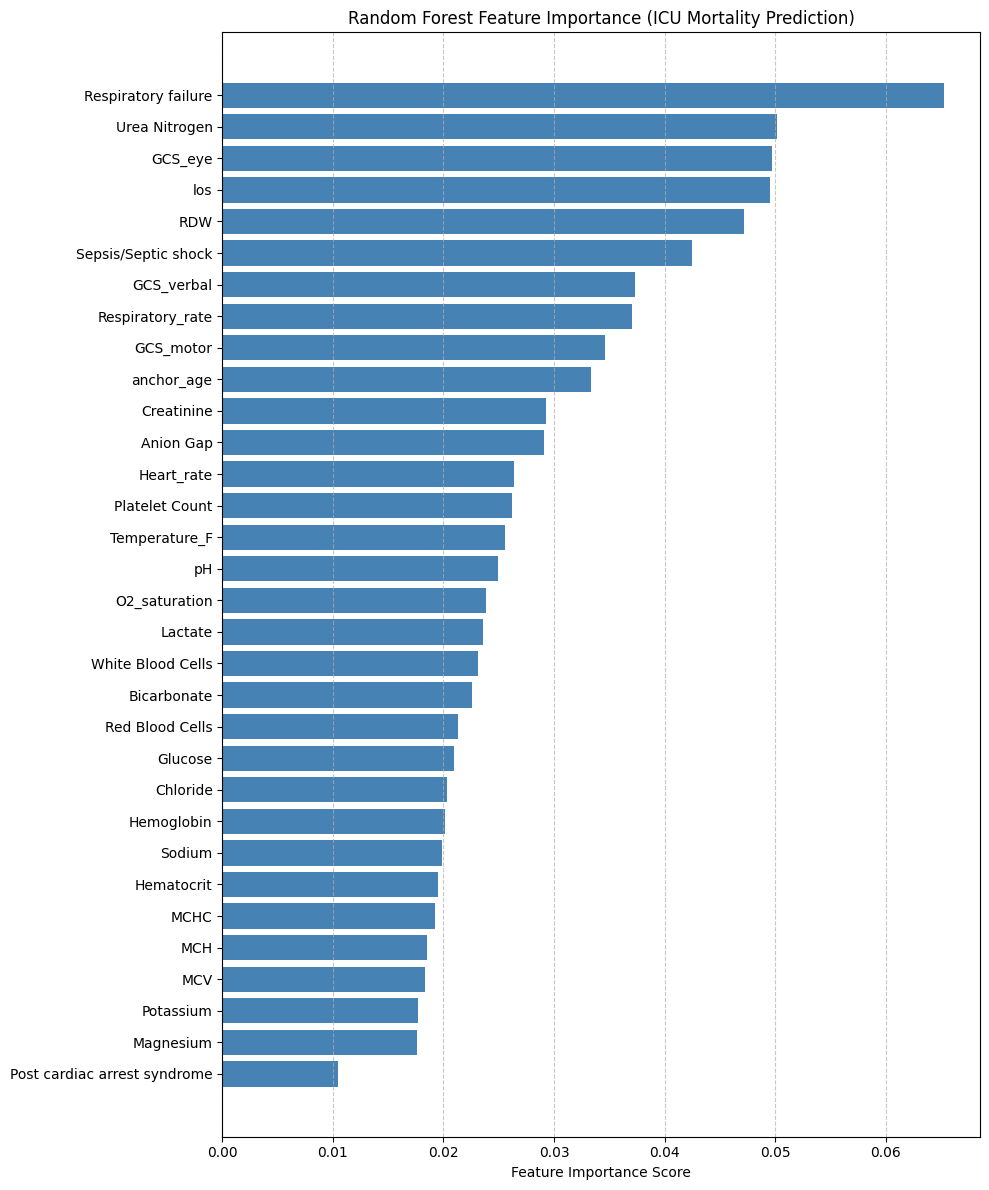

In [ ]:
# Plotting
feature_filtered = feature_imp_df[feature_imp_df["Score"] > threshold].sort_values(by="Score", ascending=True)
plt.figure(figsize=(10, 12))
plt.barh(feature_filtered["Feature"], feature_filtered["Score"], color="steelblue")
plt.xlabel("Feature Importance Score")
plt.title("Random Forest Feature Importance (ICU Mortality Prediction)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Subset training and test data for classification using selected features
selected_feature_names = selected_features['Feature'].values.tolist()
X_clf_train_selected = X_clf_train_down[selected_feature_names]
X_clf_test_selected = X_clf_test[selected_feature_names]

In [ ]:
# print new training and test data size for classification
print(f"Classification train shape: {X_clf_train_selected.shape}")
print(f"Classification test shape: {X_clf_test_selected.shape}")

Classification train shape: (12828, 32)
Classification test shape: (6298, 32)


### **Hyperparameter Tuning using GridSearch and Cross Validation**

**Defining pipelines and parameter grids for each candidate model**

**1. Logistic Regression pipeline (using scaler)**





In [ ]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2']
}

**2. Random Forest Classifier pipeline**

In [ ]:
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
param_grid_rf = {
    'clf__n_estimators': [50, 100, 200, 250],
    'clf__max_depth': [5, 10, 15],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [ 2, 4],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}

**3. XGBoost Classifier pipeline**

In [ ]:
pipe_xgb = Pipeline([
    ('clf', XGBClassifier(eval_metric='logloss', random_state=42))
])
param_grid_xgb = {
    'clf__n_estimators': range(100, 400, 100),
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__min_child_weight': [1, 5, 10],
    'clf__scale_pos_weight': [1, 3, 5],
    'clf__gamma': [0, 1, 5],
    'clf__subsample': [0.6, 0.8, 1.0]
}

**4. MLP Classifier pipeline**

In [ ]:
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(max_iter=1000, random_state=42))
])
param_grid_mlp = {
    'clf__hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50), (100, 100)],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__solver': ['adam', 'sgd'],
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
    'clf__learning_rate': ['constant', 'adaptive'],
    'clf__learning_rate_init': [0.001, 0.01, 0.1],
    'clf__early_stopping': [True]
}

In [ ]:
# Set up GridSearchCV for each model using 5-fold cross-validation and ROC AUC as scoring metric
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_mlp = GridSearchCV(pipe_mlp, param_grid_mlp, cv=5, scoring='roc_auc', n_jobs=-1)

In [ ]:
# Fit the models on the balanced training set
grid_lr.fit(X_clf_train_selected, y_clf_train_down)
grid_rf.fit(X_clf_train_selected, y_clf_train_down)
grid_xgb.fit(X_clf_train_selected, y_clf_train_down)
grid_mlp.fit(X_clf_train_selected, y_clf_train_down)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        MLPClassifier(max_iter=1000,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__activation': ['relu', 'tanh', 'logistic'],
                         'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'clf__early_stopping': [True],
                         'clf__hidden_layer_sizes': [(50,), (100,), (100, 50),
                                                     (50, 50), (100, 100)],
                         'clf__learning_rate': ['constant', 'adaptive'],
                         'clf__learning_rate_init': [0.001, 0.01, 0.1],
                         'clf__solver': ['adam', 'sgd']},
             scoring='roc_auc')

In [ ]:
print("Best Logistic Regression params:", grid_lr.best_params_)
print("Best Random Forest params:", grid_rf.best_params_)
print("Best XGBoost params:", grid_xgb.best_params_)
print("Best MLP params:", grid_mlp.best_params_)

Best Logistic Regression params: {'clf__C': 1, 'clf__penalty': 'l2'}
Best Random Forest params: {'clf__bootstrap': False, 'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 250}
Best XGBoost params: {'clf__gamma': 1, 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__min_child_weight': 5, 'clf__n_estimators': 300, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}
Best MLP params: {'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__early_stopping': True, 'clf__hidden_layer_sizes': (100, 100), 'clf__learning_rate': 'adaptive', 'clf__learning_rate_init': 0.01, 'clf__solver': 'sgd'}


In [ ]:
best_models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'MLP': grid_mlp.best_estimator_
}

### **Evaluation on Training dataset**

In [ ]:
for name, model in best_models.items():
    y_clf_pred_train = model.predict(X_clf_train_selected)
    y_clf_prob_train = model.predict_proba(X_clf_train_selected)[:, 1]
    auc = roc_auc_score(y_clf_train_down, y_clf_prob_train)
    acc = accuracy_score(y_clf_train_down, y_clf_pred_train)
    print(f"\n{name} - Training Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
    print(classification_report(y_clf_train_down, y_clf_pred_train))


Logistic Regression - Training Accuracy: 0.7936, ROC AUC: 0.8766
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      6414
           1       0.80      0.79      0.79      6414

    accuracy                           0.79     12828
   macro avg       0.79      0.79      0.79     12828
weighted avg       0.79      0.79      0.79     12828


Random Forest - Training Accuracy: 0.9917, ROC AUC: 0.9985
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6414
           1       1.00      0.98      0.99      6414

    accuracy                           0.99     12828
   macro avg       0.99      0.99      0.99     12828
weighted avg       0.99      0.99      0.99     12828


XGBoost - Training Accuracy: 0.8882, ROC AUC: 0.9613
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      6414
           1       0.88      0.90      0.89      6414

  

### **Choosing the Threshold**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Choosing XGBoost
test_model = grid_xgb.best_estimator_
y_pred = test_model.predict(X_clf_test_selected)
y_pred_prob = test_model.predict_proba(X_clf_test_selected)[:, 1]


thresholds = [i/100 for i in range(10, 100, 5)]  # Try thresholds from 0.10 to 0.95
results = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_prob >= thresh).astype(int)
    precision = precision_score(y_clf_test, y_pred_thresh)
    recall = recall_score(y_clf_test, y_pred_thresh)
    f1 = f1_score(y_clf_test, y_pred_thresh)
    results.append((thresh, precision, recall, f1))


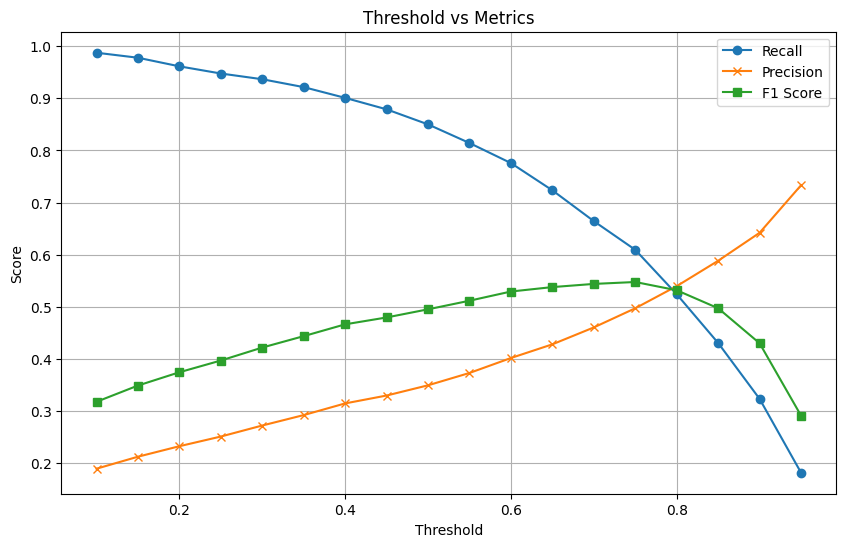

In [ ]:
df_thresh = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1'])

plt.figure(figsize=(10, 6))
plt.plot(df_thresh['Threshold'], df_thresh['Recall'], label='Recall', marker='o')
plt.plot(df_thresh['Threshold'], df_thresh['Precision'], label='Precision', marker='x')
plt.plot(df_thresh['Threshold'], df_thresh['F1'], label='F1 Score', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Metrics')
plt.legend()
plt.grid(True)
plt.show()


### **Evaluation on Test Dataset**


Logistic Regression - Test Accuracy: 0.7150, ROC AUC: 0.8717
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      5571
           1       0.28      0.90      0.42       727

    accuracy                           0.71      6298
   macro avg       0.63      0.79      0.62      6298
weighted avg       0.90      0.71      0.77      6298





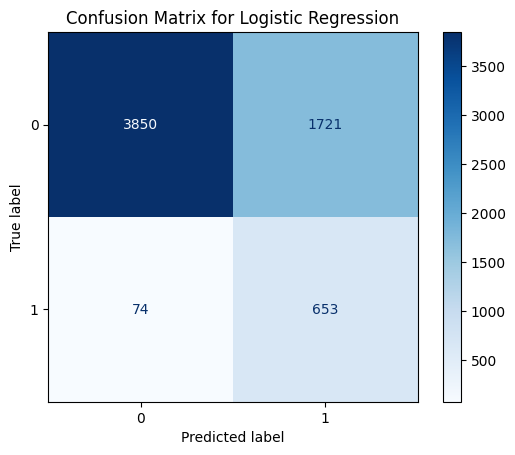


Random Forest - Test Accuracy: 0.6616, ROC AUC: 0.8921
              precision    recall  f1-score   support

           0       0.99      0.62      0.77      5571
           1       0.25      0.95      0.39       727

    accuracy                           0.66      6298
   macro avg       0.62      0.79      0.58      6298
weighted avg       0.90      0.66      0.72      6298





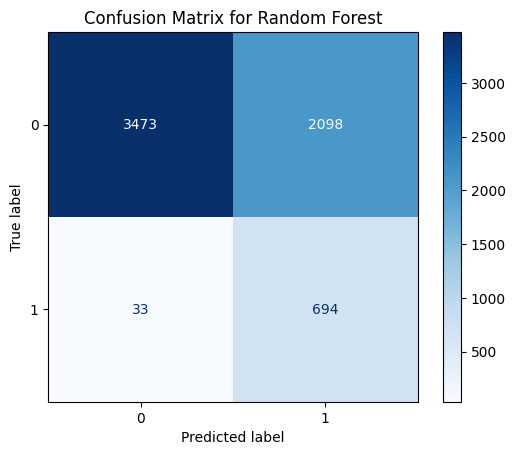


XGBoost - Test Accuracy: 0.7332, ROC AUC: 0.8994
              precision    recall  f1-score   support

           0       0.99      0.71      0.82      5571
           1       0.29      0.92      0.44       727

    accuracy                           0.73      6298
   macro avg       0.64      0.82      0.63      6298
weighted avg       0.91      0.73      0.78      6298





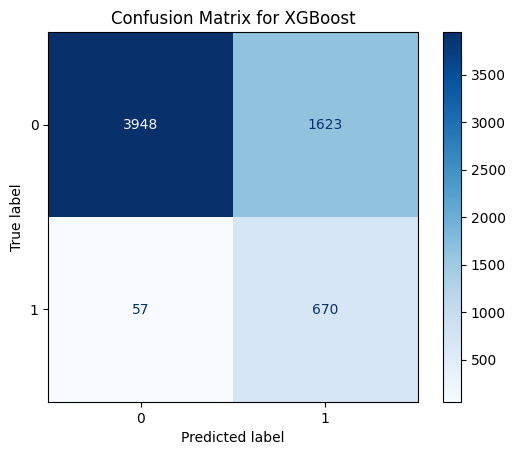


MLP - Test Accuracy: 0.7182, ROC AUC: 0.8928
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      5571
           1       0.28      0.91      0.43       727

    accuracy                           0.72      6298
   macro avg       0.63      0.80      0.62      6298
weighted avg       0.90      0.72      0.77      6298





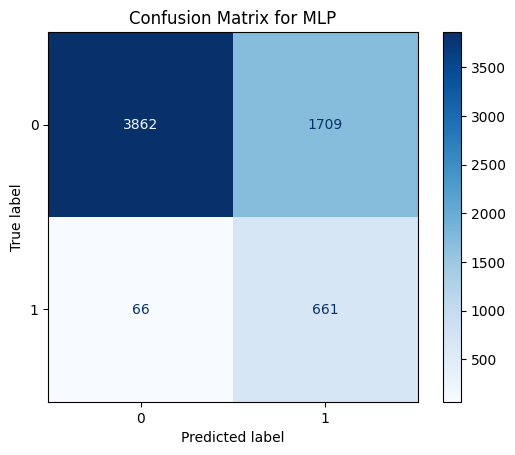

In [ ]:
def plot_confusion_matrix(y_val, y_pred, model_name):
    print("\n")
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

for name, model in best_models.items():
    y_clf_pred_test = model.predict(X_clf_test_selected)
    y_clf_prob_test = model.predict_proba(X_clf_test_selected)[:, 1]
    y_pred_new = (y_clf_prob_test >= 0.35).astype(int) #threshold less than 0.5 improves the recall rate

    auc_test = roc_auc_score(y_clf_test, y_clf_prob_test)
    acc_test = accuracy_score(y_clf_test, y_pred_new)
    print(f"\n{name} - Test Accuracy: {acc_test:.4f}, ROC AUC: {auc_test:.4f}")
    print(classification_report(y_clf_test, y_pred_new))
    #print(confusion_matrix(y_clf_test, y_pred_new))
    # Plot Confusion Matrix
    plot_confusion_matrix(y_clf_test, y_pred_new, name)

#### **ROC-AUC Curve**

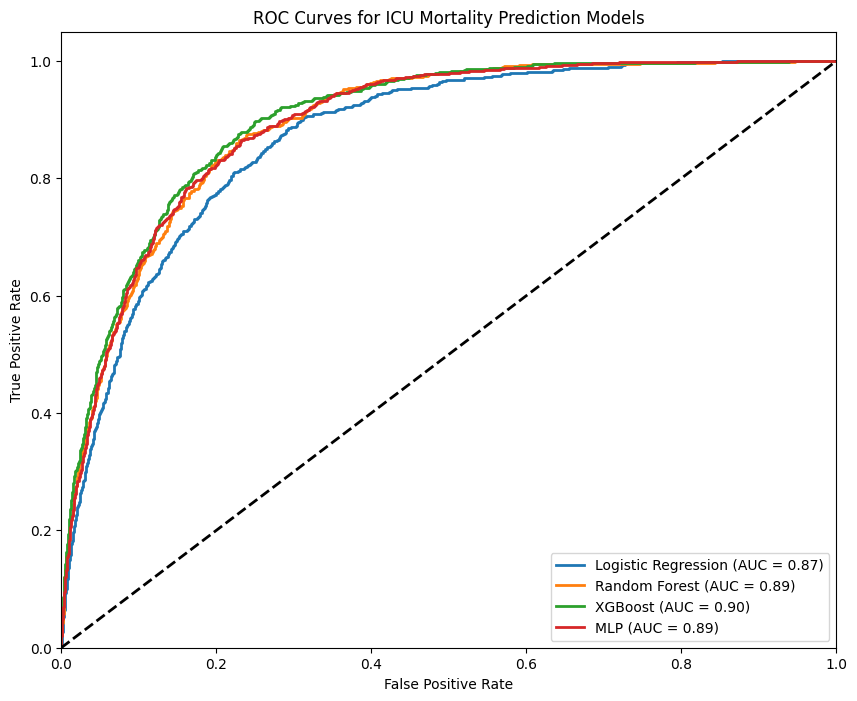

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(X_clf_test_selected)[:, 1]
    # Compute false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_clf_test, y_prob)
    # Compute Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve for the current model
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ICU Mortality Prediction Models')
plt.legend(loc='lower right')
plt.show()


#### **Precision-Recall AUC Curve**

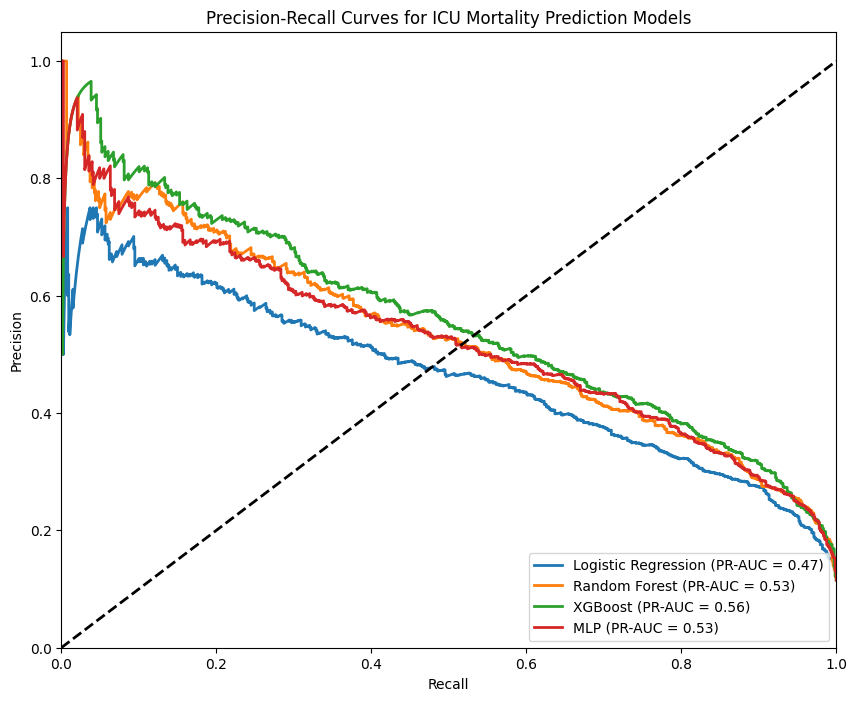

In [ ]:
# Plot PR-AUC curves for all models
plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(X_clf_test_selected)[:, 1]

    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_clf_test, y_prob)
    pr_auc = average_precision_score(y_clf_test, y_prob)

    # Plot ROC curve for the current model
    plt.plot(recall, precision, lw=2, label=f'{name} (PR-AUC = {pr_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for ICU Mortality Prediction Models')
plt.legend(loc='lower right')
plt.show()

#### **F1 Score Comparison**

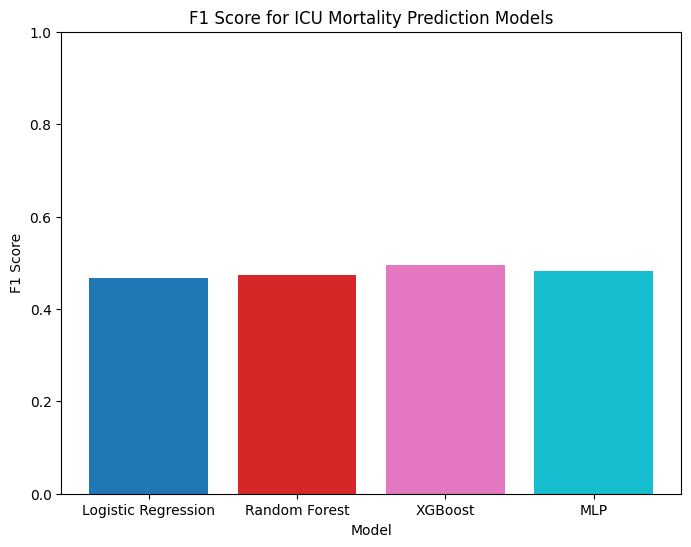

In [ ]:
# Calculate Accuracy for each model and create a bar plot
accuracy_dict = {name: f1_score(y_clf_test, model.predict(X_clf_test_selected))
                 for name, model in best_models.items()}

# Create a list of different colors using a colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(accuracy_dict)))

plt.figure(figsize=(8, 6))
plt.bar(accuracy_dict.keys(), accuracy_dict.values(), color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for ICU Mortality Prediction Models')
plt.ylim([0, 1])
plt.show()

###**Feature Importance**

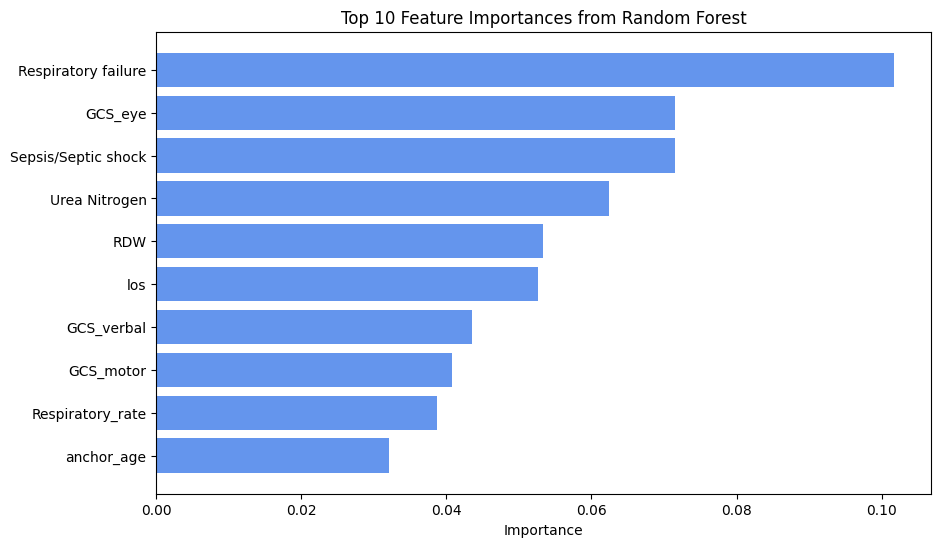

In [ ]:
# Feature Importance by Random Forest
best_rf = grid_rf.best_estimator_
rf_model = best_rf.named_steps['clf']
features = X_clf_test_selected.columns

importances = rf_model.feature_importances_
# Create a DataFrame for easier handling and sorting
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
# Sort the DataFrame by importance and select the top 10 features
top_feat_imp = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 feature importances using a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_feat_imp['Feature'], top_feat_imp['Importance'], color='cornflowerblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis so the highest importance appears on top
plt.show()

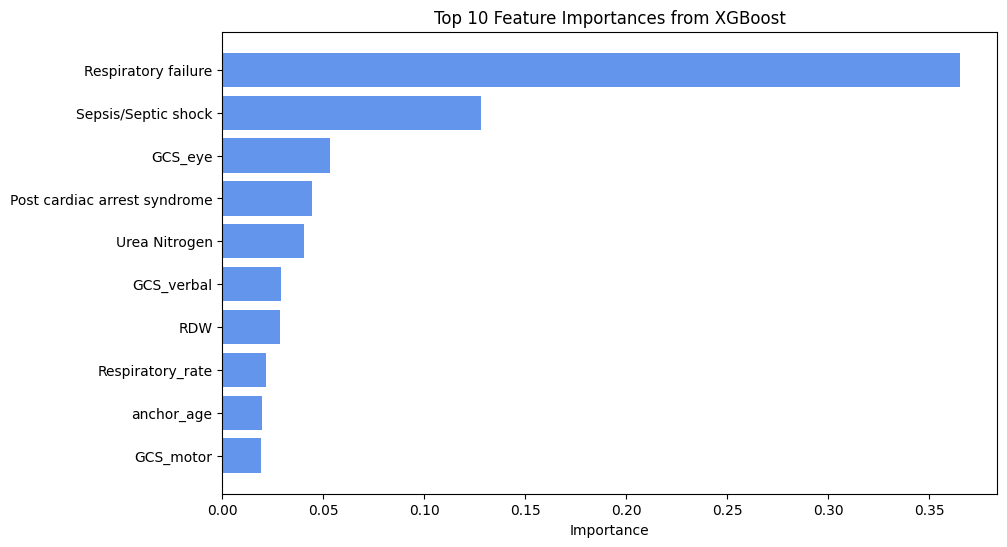

In [ ]:
# Feature Importance by XGBoost
best_xgb = grid_xgb.best_estimator_
xgb_model = best_xgb.named_steps['clf']
features = X_clf_test_selected.columns

importances = xgb_model.feature_importances_
# Create a DataFrame for easier handling and sorting
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
# Sort the DataFrame by importance and select the top 10 features
top_feat_imp = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 feature importances using a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_feat_imp['Feature'], top_feat_imp['Importance'], color='cornflowerblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis so the highest importance appears on top
plt.show()

## **Regression Modelling - Predicting ICU LOS (<= 7 days)**

### **Prepare Data**

In [ ]:
final_analyzed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62971 entries, 1 to 87892
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   los                                     62971 non-null  float64
 1   hospital_expire_flag                    62971 non-null  int64  
 2   anchor_age                              62971 non-null  int64  
 3   GCS_eye                                 62971 non-null  float64
 4   GCS_motor                               62971 non-null  float64
 5   GCS_verbal                              62971 non-null  float64
 6   Heart_rate                              62971 non-null  float64
 7   O2_saturation                           62971 non-null  float64
 8   Respiratory_rate                        62971 non-null  float64
 9   Temperature_F                           62971 non-null  float64
 10  Anion Gap                               62971 non-null  float64

Summary Statistics of LOS:
count    62971.000000
mean         4.314572
std          5.648527
min          1.000046
25%          1.589201
50%          2.446921
75%          4.592419
max        159.666806
Name: los, dtype: float64


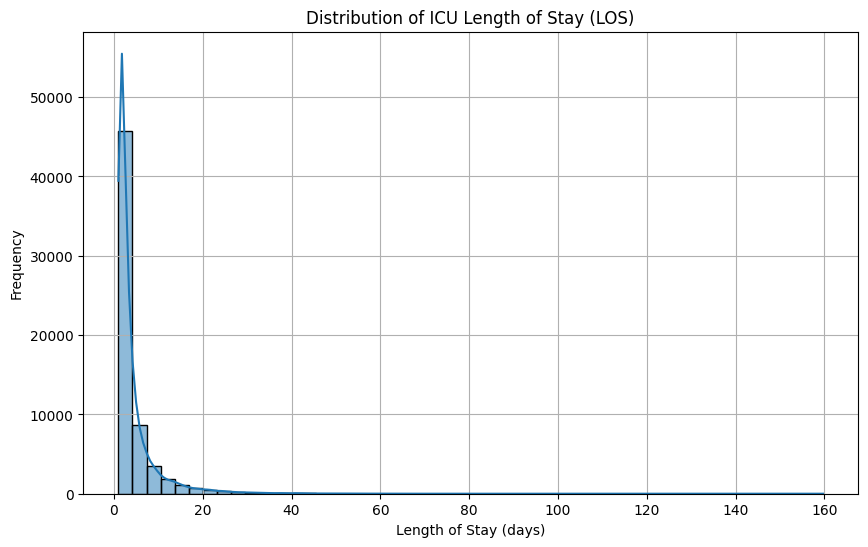

In [ ]:
# Checking Distribution of length of stay
# Summary statistics
print("Summary Statistics of LOS:")
print(final_analyzed_df['los'].describe())

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(final_analyzed_df['los'], bins=50, kde=True)
plt.title('Distribution of ICU Length of Stay (LOS)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

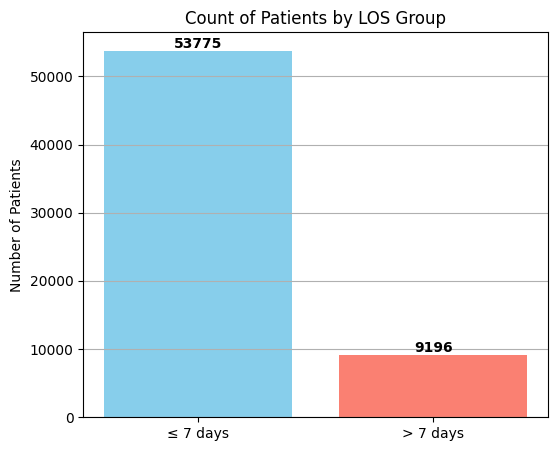

In [ ]:
# Considering only shorter stay

count_le_7 = (final_analyzed_df['los'] <= 7).sum()
count_gt_7 = (final_analyzed_df['los'] > 7).sum()

labels = ['≤ 7 days', '> 7 days']
counts = [count_le_7, count_gt_7]

plt.figure(figsize=(6, 5))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold')

plt.title('Count of Patients by LOS Group')
plt.ylabel('Number of Patients')
plt.grid(axis='y')

plt.show()

From the summary statistics, we find that:
  * Majority of patients had relatively short period of hospitalization. The distribution is highly right-skewed, with most LOS values concentrated below 20 days.
  * Summary statistics indicate a median LOS of approximately 1.68 days, while the mean is higher at around 4.28 days, suggesting the presence of outliers with extended stays.
  * When categorizing patients into two groups—those with LOS ≤ 7 days and those with LOS > 7 days—an overwhelming majority (approximately 33,775 patients) fell into the ≤ 7 days category, while only 9,196 patients exceeded this duration.

This clear disparity highlights that short ICU stays are far more common, which may reflect efficient care protocols, lower severity for many admissions, or quick transitions to other levels of care.
Hence we limit our analysis for this study to shorter ICU stays (los <= 7days)

Another thing to consider is admissions of patients who died at the hospital. This kind of admissions resulting in death will be excluded as they would bias the LOS since LOS would be shorter for this group.

In [ ]:
# Keep records where los<= 7 and are survivors
final_df_7 = final_analyzed_df[(final_analyzed_df['los'] <= 7) & (final_analyzed_df['hospital_expire_flag'] == 0)]

In [ ]:
final_df_7.shape

(48825, 61)

In [ ]:
# Hospital LOS metrics for later comparison
actual_mean_los = final_df_7['los'].mean()
actual_median_los = final_df_7['los'].median()

print(actual_mean_los)
print(actual_median_los)

2.544799326297624
2.0724074074074075


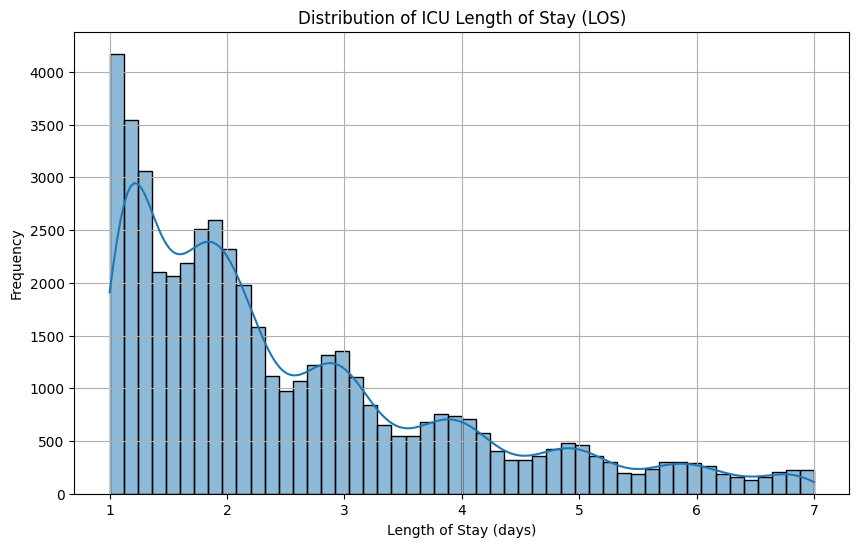

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(final_df_7['los'], bins=50, kde=True)
plt.title('Distribution of ICU Length of Stay (LOS)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

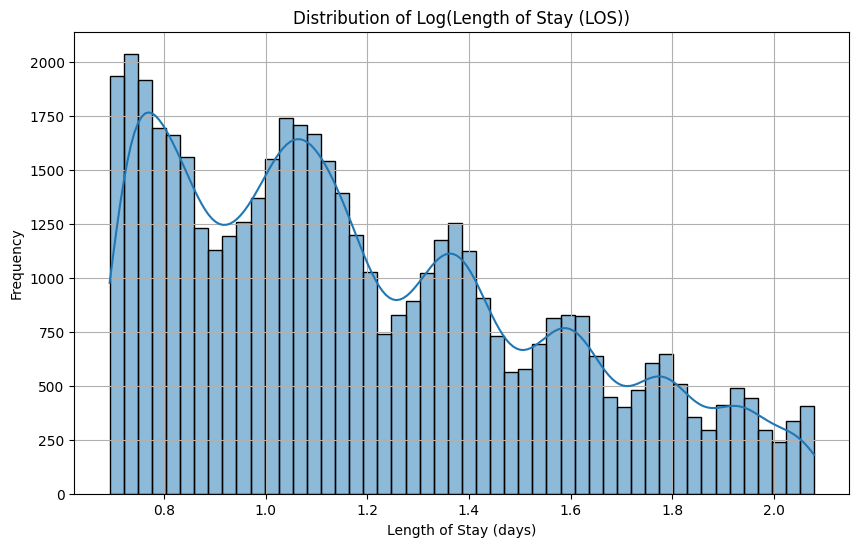

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(final_df_7['los']), bins=50, kde=True)
plt.title('Distribution of Log(Length of Stay (LOS))')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Since the los data is highly right-skewed, hence we will use log transformation**

### **Data Splitting**

**Split Data: Into Target and Feature**

In [ ]:
# For regression :ICU Length of Stay prediction
target_reg = 'los'

# Drop target columns from features
features_reg = final_df_7.drop(columns=[target_reg])

X_reg = features_reg
y_reg = final_df_7[target_reg]

# Log-transform the target
y_log = np.log1p(y_reg)

**Split Data: Into Training and Test sets**

In [ ]:
# For regression
X_reg_train, X_reg_test, y_train_log, y_test_log = train_test_split(X_reg, y_log, test_size=0.2, random_state=42)

In [ ]:
# print shape of training set and test set for regression
print(f"Regression train shape: {X_reg_train.shape}")
print(f"Regression test shape: {X_reg_test.shape}")

Regression train shape: (39060, 60)
Regression test shape: (9765, 60)


### **Feature Selection using Lasso for Regression**

In [ ]:
# Use LassoCV to select features (using 5-fold CV)
lasso_cv = Pipeline([
            ('normalize', StandardScaler()),
            ('lasso', LassoCV(cv=5, alphas=np.logspace(-4, 1, 100), random_state=42))
          ])
lasso_cv.fit(X_reg_train, y_train_log)

Pipeline(steps=[('normalize', StandardScaler()),
                ('lasso',
                 LassoCV(alphas=array([1.00000000e-04, 1.12332403e-04, 1.26185688e-04, 1.41747416e-04,
       1.59228279e-04, 1.78864953e-04, 2.00923300e-04, 2.25701972e-04,
       2.53536449e-04, 2.84803587e-04, 3.19926714e-04, 3.59381366e-04,
       4.03701726e-04, 4.53487851e-04, 5.09413801e-04, 5.72236766e-04,
       6.42807312e-04, 7.22080902e-04, 8....
       6.89261210e-01, 7.74263683e-01, 8.69749003e-01, 9.77009957e-01,
       1.09749877e+00, 1.23284674e+00, 1.38488637e+00, 1.55567614e+00,
       1.74752840e+00, 1.96304065e+00, 2.20513074e+00, 2.47707636e+00,
       2.78255940e+00, 3.12571585e+00, 3.51119173e+00, 3.94420606e+00,
       4.43062146e+00, 4.97702356e+00, 5.59081018e+00, 6.28029144e+00,
       7.05480231e+00, 7.92482898e+00, 8.90215085e+00, 1.00000000e+01]),
                         cv=5, random_state=42))])

In [ ]:
# Get the best alpha
best_alpha = lasso_cv.named_steps['lasso'].alpha_
print("Best alpha:", best_alpha)

Best alpha: 0.0001


In [ ]:
lasso_model = lasso_cv.named_steps['lasso']

# Create a DataFrame with feature names and their coefficients
feature_coef_df = pd.DataFrame({
    'Feature': X_reg_train.columns,
    'Coefficient': lasso_model.coef_
})

# Sort by absolute value of the coefficient (optional)
feature_coef_df['Abs_Coefficient'] = feature_coef_df['Coefficient'].abs()
feature_coef_df = feature_coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display all features with coefficients
print(feature_coef_df)

                                   Feature  Coefficient  Abs_Coefficient
45                first_careunit_Neuro ICU     0.082892         0.082892
4                               GCS_verbal    -0.067890         0.067890
2                                  GCS_eye    -0.034253         0.034253
14                              Hematocrit    -0.032671         0.032671
40                     Respiratory failure     0.031361         0.031361
11                                Chloride    -0.024724         0.024724
33                           Heart failure     0.024199         0.024199
7                         Respiratory_rate     0.020513         0.020513
5                               Heart_rate     0.019888         0.019888
47             first_careunit_Surgical ICU     0.019418         0.019418
15                              Hemoglobin     0.018693         0.018693
48                admission_type_Emergency     0.018423         0.018423
26                           Urea Nitrogen     0.01

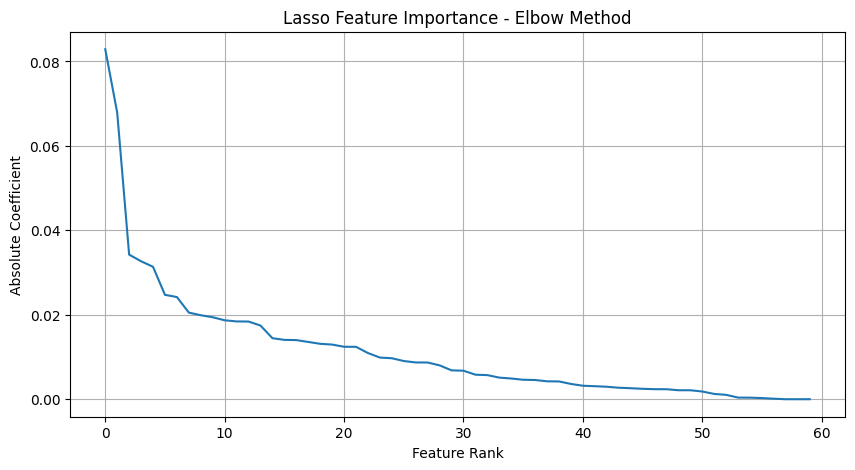

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(feature_coef_df)), feature_coef_df['Abs_Coefficient'].sort_values(ascending=False).values)
plt.xlabel('Feature Rank')
plt.ylabel('Absolute Coefficient')
plt.title('Lasso Feature Importance - Elbow Method')
plt.grid(True)
plt.show()


In [ ]:
# Select top 15 features
top_n = 15
selected_features = feature_coef_df.head(top_n)
print("Selected features using LassoCV for regression:")
print(selected_features)

Selected features using LassoCV for regression:
                        Feature  Coefficient  Abs_Coefficient
45     first_careunit_Neuro ICU     0.082892         0.082892
4                    GCS_verbal    -0.067890         0.067890
2                       GCS_eye    -0.034253         0.034253
14                   Hematocrit    -0.032671         0.032671
40          Respiratory failure     0.031361         0.031361
11                     Chloride    -0.024724         0.024724
33                Heart failure     0.024199         0.024199
7              Respiratory_rate     0.020513         0.020513
5                    Heart_rate     0.019888         0.019888
47  first_careunit_Surgical ICU     0.019418         0.019418
15                   Hemoglobin     0.018693         0.018693
48     admission_type_Emergency     0.018423         0.018423
26                Urea Nitrogen     0.018395         0.018395
34       Hematological diseases     0.017448         0.017448
24              Red Bl

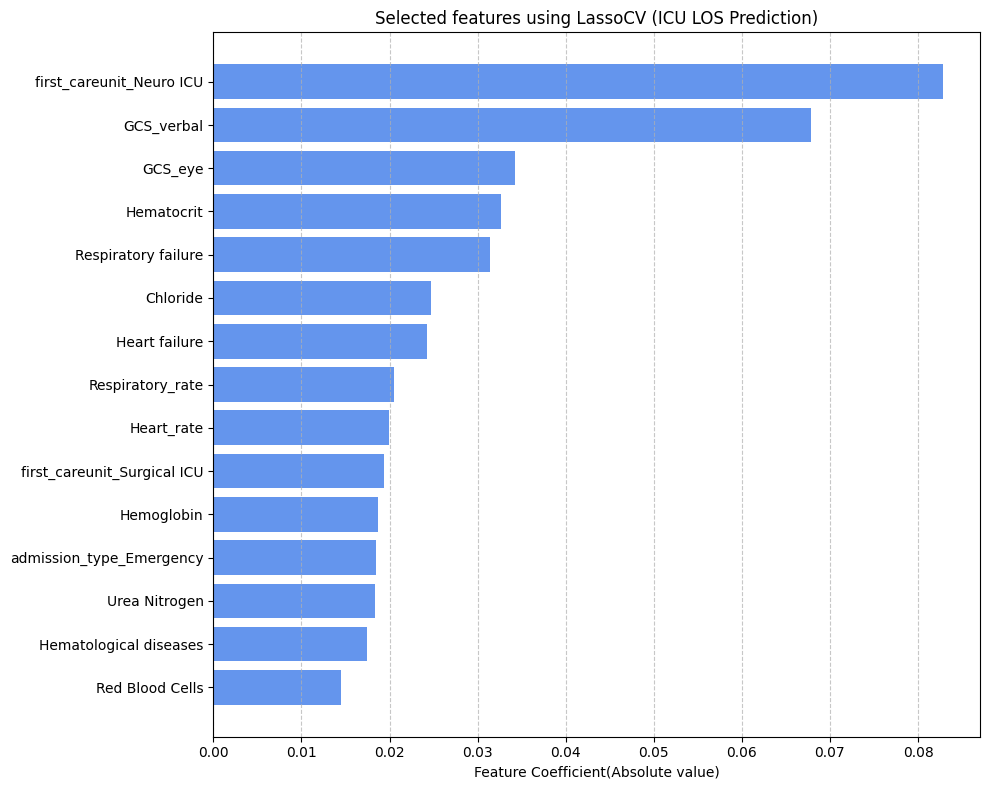

In [ ]:
# Plotting
sorted_df = selected_features.sort_values(by='Abs_Coefficient', ascending=True)
plt.figure(figsize=(10, 8))
plt.barh(sorted_df["Feature"], sorted_df["Abs_Coefficient"], color='cornflowerblue')
plt.xlabel("Feature Coefficient(Absolute value)")
plt.title("Selected features using LassoCV (ICU LOS Prediction)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Subset training and test data for regression using selected features
selected_feature_names = selected_features['Feature'].values.tolist()
X_reg_train_selected = X_reg_train[selected_feature_names]
X_reg_test_selected = X_reg_test[selected_feature_names]

In [ ]:
# print new training and test data size for regression
print(f"Regression train shape: {X_reg_train_selected.shape}")
print(f"Regression test shape: {X_reg_test_selected.shape}")

Regression train shape: (39060, 15)
Regression test shape: (9765, 15)


### **Regression models**

In [ ]:
# Regression models used from scikit-learn for comparison
models = [LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0),
          XGBRegressor(random_state = 0)]

results = {}

for model in models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_reg_train_selected, y_train_log)

    # Make predictions with model on training
    y_train_preds_log = reg_model.predict(X_reg_train_selected)

    # Convert back to original scale
    y_train_preds = np.expm1(y_train_preds_log)
    y_reg_train = np.expm1(y_train_log)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    #results[name] = r2_score(y_reg_train, y_train_preds)
    results[name] = mean_absolute_error(y_reg_train, y_train_preds)
    print('{} done.'.format(name))

LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.
XGBRegressor done.


In [ ]:
results

{'LinearRegression': 0.9816384174419656,
 'KNeighborsRegressor': 0.8971819557850522,
 'RandomForestRegressor': 0.37807099833741936,
 'XGBRegressor': 0.8016072694167925}

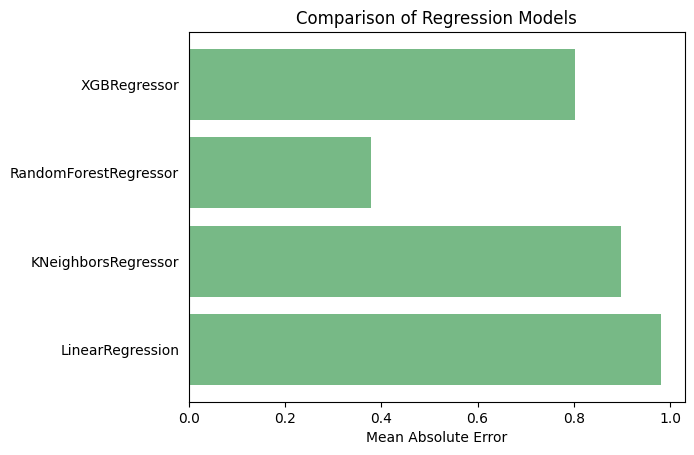

In [ ]:
# Mean Absolute Error results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('Mean Absolute Error')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
plt.show()

From the above analysis we find that RandomForest Regressor has the least error.

Next we will proceed with hyperparameter tuning and check how much the scores are improved

### **Hyperparameter Tuning using GridSearch and Cross Validation**

**Defining pipelines and parameter grids for each candidate regressor**

**ElasticNet Regression** (Regularized version of Linear Regression)

In [ ]:
pipe_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(max_iter=10000, random_state=42))
])

param_elastic = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

**KNeighbors Regressor**

In [ ]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

param_knn = {
    'knn__n_neighbors': [30, 50, 100, 150, 200],
    'knn__weights': ['uniform', 'distance']
}

**Random Forest Regressor pipeline**

In [ ]:
pipe_rf_reg = Pipeline([
    ('reg', RandomForestRegressor(random_state=42))
])
param_rf_reg = {
    'reg__n_estimators': [50, 100, 200],
    'reg__max_depth': [100, 500, 1000],
    'reg__max_features': ['sqrt', 'log2'],
    'reg__bootstrap': [True, False]
}

**XGBoost Regressor pipeline**

In [ ]:
pipe_xgb_reg = Pipeline([
    ('reg', XGBRegressor(objective='reg:squarederror', random_state=42))
])
param_xgb_reg = {
    'reg__n_estimators': [100, 200, 300],
    'reg__max_depth': [3, 5, 7],
    'reg__learning_rate': [0.01, 0.05, 0.1]
}

In [ ]:
# Set up GridSearchCV or RandomisedSearch for each of the model using 5-fold cross-validation and MAE as scoring metric
scoring = 'neg_mean_absolute_error'
grid_elastic = GridSearchCV(pipe_elastic, param_grid=param_elastic,cv=5, scoring=scoring, n_jobs=-1)
grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring=scoring, n_jobs=-1)
grid_rf = GridSearchCV(pipe_rf_reg, param_rf_reg, cv=5, scoring=scoring, n_jobs=-1, verbose=2)
grid_xgb = GridSearchCV(pipe_xgb_reg, param_xgb_reg, cv=5, scoring=scoring, n_jobs=-1)

In [ ]:
# Fit the models on the training set
grid_elastic.fit(X_reg_train_selected, y_train_log)
grid_knn.fit(X_reg_train_selected, y_train_log)
grid_rf.fit(X_reg_train_selected, y_train_log)
grid_xgb.fit(X_reg_train_selected, y_train_log)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     feature_weights=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     inter...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'reg__learning_rate': [0.01, 0.05, 0.1],
                         'reg__max_depth': [3, 5, 7],
                         'reg__n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [ ]:
print("Best ElasticNet Regression params:", grid_elastic.best_params_)
print("Best KNN Regression params:", grid_knn.best_params_)
print("Best Random Forest params:", grid_rf.best_params_)
print("Best XGBoost params:", grid_xgb.best_params_)

Best ElasticNet Regression params: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}
Best KNN Regression params: {'knn__n_neighbors': 150, 'knn__weights': 'distance'}
Best Random Forest params: {'reg__bootstrap': True, 'reg__max_depth': 100, 'reg__max_features': 'sqrt', 'reg__n_estimators': 200}
Best XGBoost params: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 200}


In [ ]:
best_reg_models = {
    'ElasticNet Regression': grid_elastic.best_estimator_,
    'KNN Regression': grid_knn.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_
}

### **Evaluation on Training set**

In [ ]:
# Evaluate each tuned regressor on the test set
print("\n--- Evaluation on Training Set (Regression) ---")
for name, grid in best_reg_models.items():
    y_reg_pred_train_log = grid.predict(X_reg_train_selected)
    # Convert back to original scale
    y_reg_pred_train = np.expm1(y_reg_pred_train_log)
    y_reg_train = np.expm1(y_train_log)

    # Evaluate on original scale
    mean_cv_score = cross_val_score(grid, X_reg_train_selected, y_reg_train, cv=5, scoring=scoring).mean()
    rmse_train = root_mean_squared_error(y_reg_train, y_reg_pred_train)
    mae_train = mean_absolute_error(y_reg_train, y_reg_pred_train)
    medae_train = median_absolute_error(y_reg_train, y_reg_pred_train)
    mape_train = mean_absolute_percentage_error(y_reg_train, y_reg_pred_train)
    r2_train = r2_score(y_reg_train, y_reg_pred_train)
    print(f"\nResults for {name}:")
    print(f"Best CV score with MAE: {-mean_cv_score:.4f}")
    print(f"Train R2: {r2_train:.4f}")
    print(f"Train MAE: {mae_train:.4f}")
    print(f"Train Median Absolute Error: {medae_train:.4f}")
    print(f"Train Mean Absolute Percentage Error: {mape_train:.4f}")
    print(f"Train RMSE: {rmse_train:.4f}")



--- Evaluation on Training Set (Regression) ---

Results for ElasticNet Regression:
Best CV score with MAE: 1.0157
Train R2: 0.1378
Train MAE: 0.9817
Train Median Absolute Error: 0.7545
Train Mean Absolute Percentage Error: 0.4215
Train RMSE: 1.3158

Results for KNN Regression:
Best CV score with MAE: 0.9891
Train R2: 1.0000
Train MAE: 0.0000
Train Median Absolute Error: 0.0000
Train Mean Absolute Percentage Error: 0.0000
Train RMSE: 0.0000

Results for Random Forest:
Best CV score with MAE: 1.0067
Train R2: 0.8522
Train MAE: 0.3764
Train Median Absolute Error: 0.2570
Train Mean Absolute Percentage Error: 0.1492
Train RMSE: 0.5448

Results for XGBoost:
Best CV score with MAE: 0.9934
Train R2: 0.1920
Train MAE: 0.9442
Train Median Absolute Error: 0.7097
Train Mean Absolute Percentage Error: 0.4024
Train RMSE: 1.2739


### **Evaluation on Test Set**

In [ ]:
# Evaluate each tuned regressor on the test set
print("\n--- Evaluation on Test Set (Regression) ---")
for name, grid in best_reg_models.items():
    y_reg_pred_test_log = grid.predict(X_reg_test_selected)
    # Convert back to original scale
    y_reg_pred_test = np.expm1(y_reg_pred_test_log)
    y_reg_test = np.expm1(y_test_log)

    # Evaluate on original scale
    mean_cv_score_test = cross_val_score(grid, X_reg_test_selected, y_reg_test, cv=5, scoring=scoring).mean()
    rmse_test = root_mean_squared_error(y_reg_test, y_reg_pred_test)
    mae_test = mean_absolute_error(y_reg_test, y_reg_pred_test)
    medae_test = median_absolute_error(y_reg_test, y_reg_pred_test)
    mape_test = mean_absolute_percentage_error(y_reg_test, y_reg_pred_test)
    r2_test = r2_score(y_reg_test, y_reg_pred_test)

    print(f"\nResults for {name}:")
    print(f"Best CV score with MAE: {-mean_cv_score_test:.4f}")
    print(f"Test R2: {r2_test: .4f}")
    print(f"Test MAE: {mae_test: .4f}")
    print(f"Test Median Absolute Error: {medae_test:.4f}")
    print(f"Test Mean Absolute Percentage Error: {mape_test:.4f}")
    print(f"Test RMSE: {rmse_test:.4f}")



--- Evaluation on Test Set (Regression) ---

Results for ElasticNet Regression:
Best CV score with MAE: 0.9972
Test R2:  0.1470
Test MAE:  0.9661
Test Median Absolute Error: 0.7409
Test Mean Absolute Percentage Error: 0.4151
Test RMSE: 1.2945

Results for KNN Regression:
Best CV score with MAE: 0.9765
Test R2:  0.1303
Test MAE:  0.9550
Test Median Absolute Error: 0.6925
Test Mean Absolute Percentage Error: 0.3938
Test RMSE: 1.3071

Results for Random Forest:
Best CV score with MAE: 0.9977
Test R2:  0.1662
Test MAE:  0.9540
Test Median Absolute Error: 0.7239
Test Mean Absolute Percentage Error: 0.4110
Test RMSE: 1.2798

Results for XGBoost:
Best CV score with MAE: 0.9851
Test R2:  0.1780
Test MAE:  0.9432
Test Median Absolute Error: 0.7101
Test Mean Absolute Percentage Error: 0.4036
Test RMSE: 1.2708


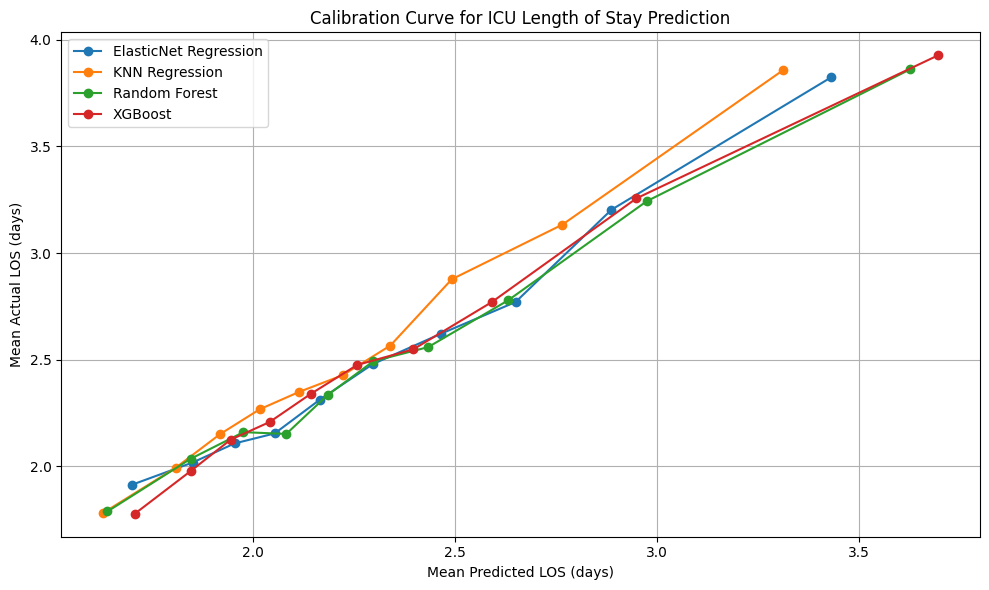

In [ ]:
# Plotting Calibration Curve

n_bins = 10
plt.figure(figsize=(10, 6))

for name, model in best_reg_models.items():
    y_pred_log = model.predict(X_reg_test_selected)
    # Convert back to original scale
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)

    # Create a DataFrame for binning
    df = pd.DataFrame({'y_pred': y_pred, 'y_true': y_true})
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')

    bin_avg_pred = df.groupby('bin', observed=False)['y_pred'].mean()
    bin_avg_true = df.groupby('bin', observed=False)['y_true'].mean()

    # Plot calibration
    plt.plot(bin_avg_pred, bin_avg_true, marker='o', label=f"{name}")

plt.xlabel("Mean Predicted LOS (days)")
plt.ylabel("Mean Actual LOS (days)")
plt.title("Calibration Curve for ICU Length of Stay Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()